In [1]:
import polars as pl
import pandas as pd
import numpy as np
# import pyarrow
import duckdb

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style()
plt.style.use("seaborn-v0_8-dark")
import sweetviz as sv

In [3]:
df = pl.read_csv('02_data_original/ML_cars.csv')

In [4]:
df.head(1)

car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
i64,i64,str,str,str,str,str,str,str,f64,f64,f64,f64,i64,str,str,i64,str,f64,f64,f64,i64,i64,i64,i64,f64
1,3,"""alfa-romero giulia""","""gas""","""std""","""two""","""convertible""","""rwd""","""front""",88.6,168.8,64.1,48.8,2548,"""dohc""","""four""",130,"""mpfi""",3.47,2.68,9.0,111,5000,21,27,13495.0


Divido la Columna `CarName` en dos columnas nuevas, una que contenga la Marca: `Brand` y otra que contenga el Modelo: `Name`, despues elimino la Columna `CarName`

In [5]:
df = df.with_columns(
    pl.col('CarName')
    .str.split_exact(" ", 1)
    .struct.rename_fields(["Brand", "Name"])
    .alias("fields")
).unnest("fields")

df = df.drop('CarName')

In [6]:
df['Name'].unique().count()

114

Importante a Tomar encuenta.  
- En cualquier estudio de precios en la Actualidad conocer el nombre del Modelo del vehículo sería fundamental para una predicción de Precios.   
- Sin embargo solo contamos con 205 registros y 114 Modelos diferentes, es decir No hay siquiera 2 registros por Modelo, Lo que haría que un modelo tendiera a aprenderse los datos de memoria.
- Por lo antigua de la Data no puede ser completada con Data Actual proveniente de un Web-Scraping, ya que por la relacion de Tamaño de motor - potencia de los mismos - pesos de los vehiculos se estan hablando de vehiculos de la decada de los 70 u 80  

En la Data se observaron Nombres mal escritos de Marcas y diferencias a la Hora de escribirlos.. Por lo que se procede a corregir dichos errores y a pasar a todos a Letra-Capital (primera en Mayuscula), para Normalizar la data

In [7]:
df = df.with_columns(
    Brand = pl.when(pl.col('Brand') == 'porcshce').then(pl.lit('porsche'))
              .when(pl.col('Brand') == 'toyouta').then(pl.lit('toyota'))
              .when(pl.col('Brand') == 'alfa-romero').then(pl.lit('alfa-romeo'))
              .when(pl.col('Brand') == 'maxda').then(pl.lit('mazda'))
              .when(pl.col('Brand') == 'vokswagen').then(pl.lit('volkswagen'))
              .when(pl.col('Brand') == 'vw').then(pl.lit('volkswagen'))
              .otherwise(pl.col('Brand'))
)

df = df.with_columns(
    Brand = pl.col('Brand').str.to_titlecase()
)

In [8]:
df['Brand'].unique().count()

22

In [9]:
print(df.shape)
df.head()

(205, 27)


car_ID,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,Brand,Name
i64,i64,str,str,str,str,str,str,f64,f64,f64,f64,i64,str,str,i64,str,f64,f64,f64,i64,i64,i64,i64,f64,str,str
1,3,"""gas""","""std""","""two""","""convertible""","""rwd""","""front""",88.6,168.8,64.1,48.8,2548,"""dohc""","""four""",130,"""mpfi""",3.47,2.68,9.0,111,5000,21,27,13495.0,"""Alfa-Romeo""","""giulia"""
2,3,"""gas""","""std""","""two""","""convertible""","""rwd""","""front""",88.6,168.8,64.1,48.8,2548,"""dohc""","""four""",130,"""mpfi""",3.47,2.68,9.0,111,5000,21,27,16500.0,"""Alfa-Romeo""","""stelvio"""
3,1,"""gas""","""std""","""two""","""hatchback""","""rwd""","""front""",94.5,171.2,65.5,52.4,2823,"""ohcv""","""six""",152,"""mpfi""",2.68,3.47,9.0,154,5000,19,26,16500.0,"""Alfa-Romeo""","""Quadrifoglio"""
4,2,"""gas""","""std""","""four""","""sedan""","""fwd""","""front""",99.8,176.6,66.2,54.3,2337,"""ohc""","""four""",109,"""mpfi""",3.19,3.4,10.0,102,5500,24,30,13950.0,"""Audi""","""100"""
5,2,"""gas""","""std""","""four""","""sedan""","""4wd""","""front""",99.4,176.6,66.4,54.3,2824,"""ohc""","""five""",136,"""mpfi""",3.19,3.4,8.0,115,5500,18,22,17450.0,"""Audi""","""100ls"""


<img src='01_propuesta_proyecto/campos_dataset_carros.jpg'>

Reviso la cantidad de Nulos por columna

In [10]:
for column in df.columns:
    print(f'Cantidad de nulos: {df[column].is_null().sum()}  ---> Columna: {column}')

Cantidad de nulos: 0  ---> Columna: car_ID
Cantidad de nulos: 0  ---> Columna: symboling
Cantidad de nulos: 0  ---> Columna: fueltype
Cantidad de nulos: 0  ---> Columna: aspiration
Cantidad de nulos: 0  ---> Columna: doornumber
Cantidad de nulos: 0  ---> Columna: carbody
Cantidad de nulos: 0  ---> Columna: drivewheel
Cantidad de nulos: 0  ---> Columna: enginelocation
Cantidad de nulos: 0  ---> Columna: wheelbase
Cantidad de nulos: 0  ---> Columna: carlength
Cantidad de nulos: 0  ---> Columna: carwidth
Cantidad de nulos: 0  ---> Columna: carheight
Cantidad de nulos: 0  ---> Columna: curbweight
Cantidad de nulos: 0  ---> Columna: enginetype
Cantidad de nulos: 0  ---> Columna: cylindernumber
Cantidad de nulos: 0  ---> Columna: enginesize
Cantidad de nulos: 0  ---> Columna: fuelsystem
Cantidad de nulos: 0  ---> Columna: boreratio
Cantidad de nulos: 0  ---> Columna: stroke
Cantidad de nulos: 0  ---> Columna: compressionratio
Cantidad de nulos: 0  ---> Columna: horsepower
Cantidad de nulos: 

Solo 2 Nulos en Nombre del Modelo.. Como No voy a utilizar esa columna como predictora igual puedo proceder sin eliminar esos nulos

In [11]:
df.write_csv('03_data_procesada/01_data_pro_2.csv')

In [12]:
reporte_precio = sv.analyze(df.to_pandas(), target_feat='price')

                                             |          | [  0%]   00:00 -> (? left)


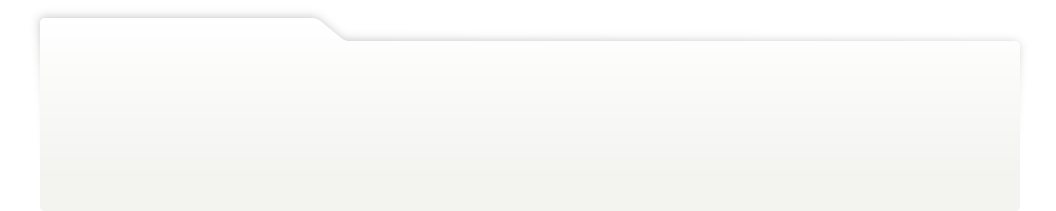
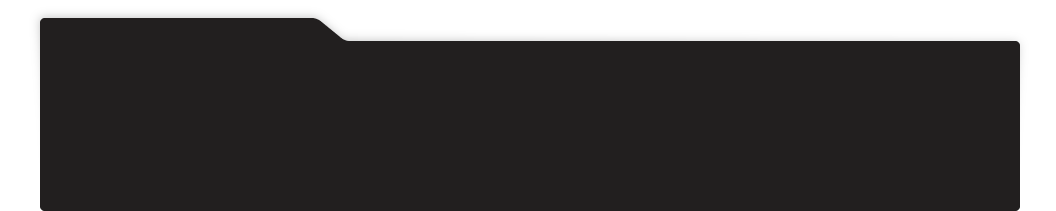
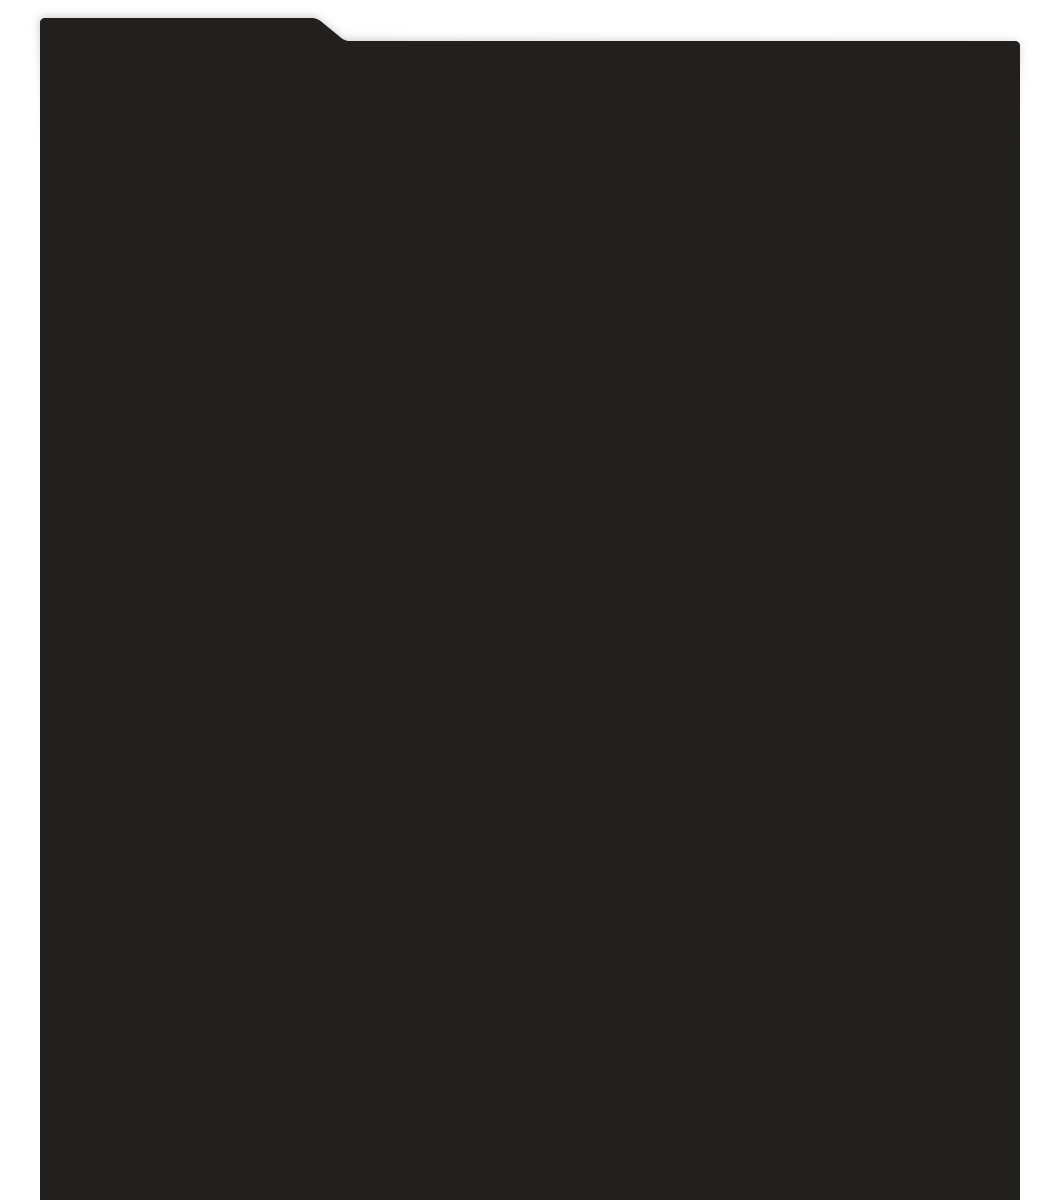
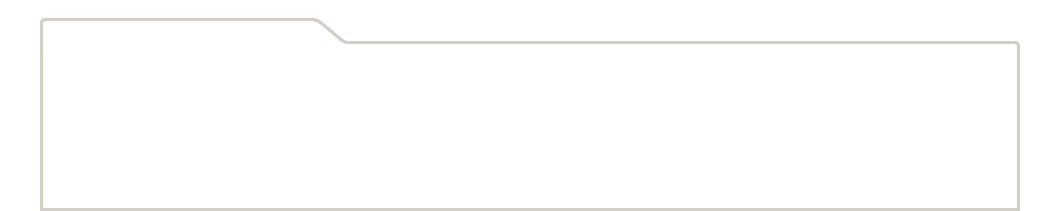
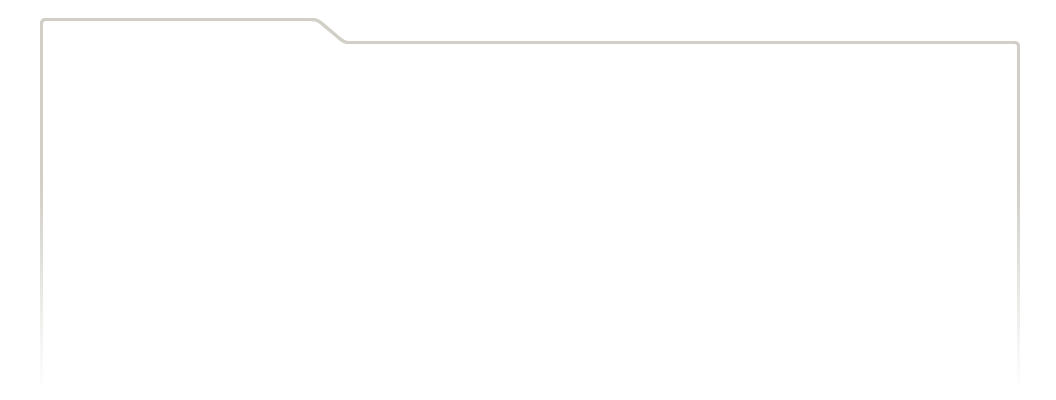
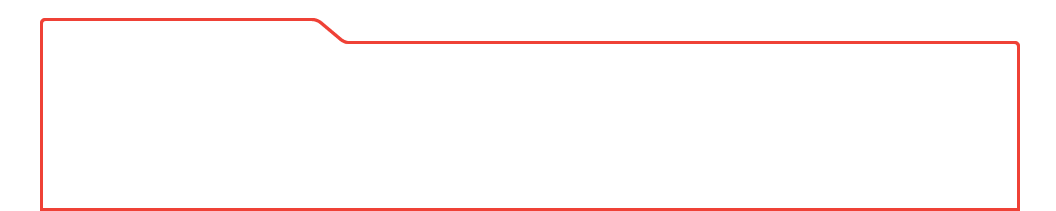
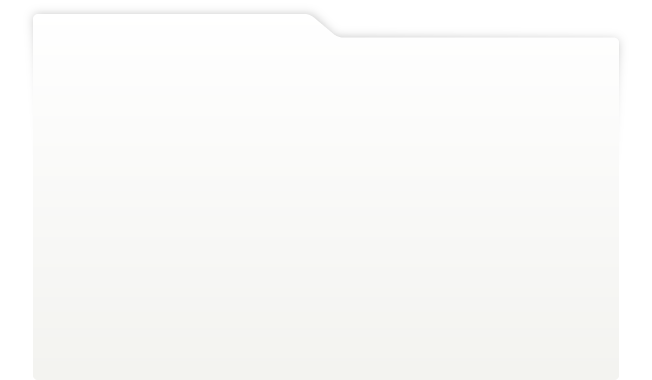
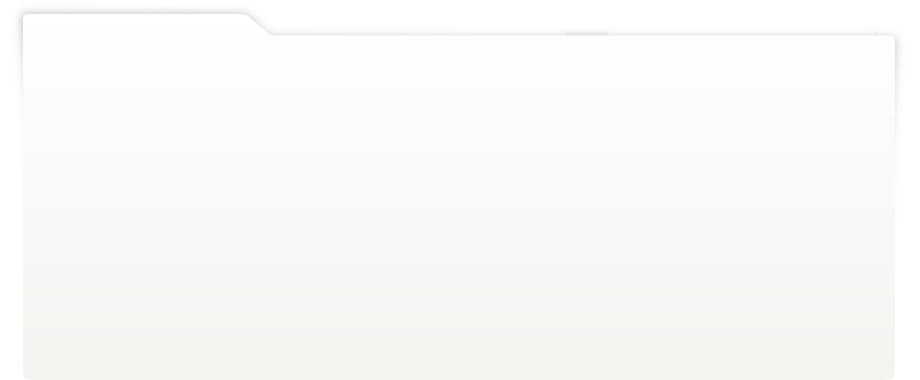
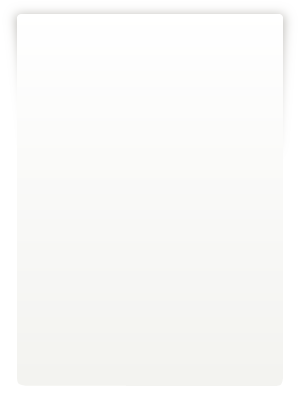
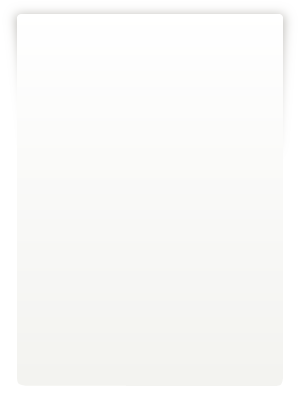
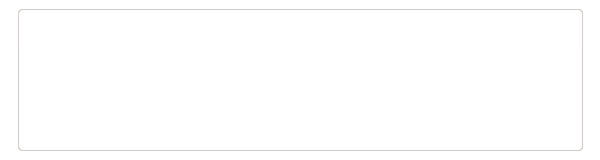
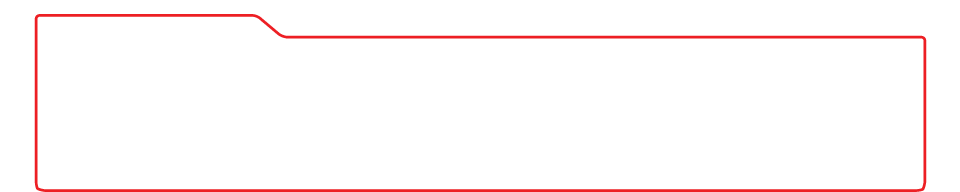
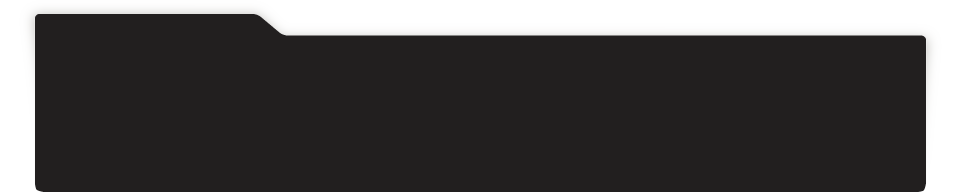
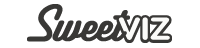
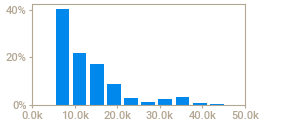
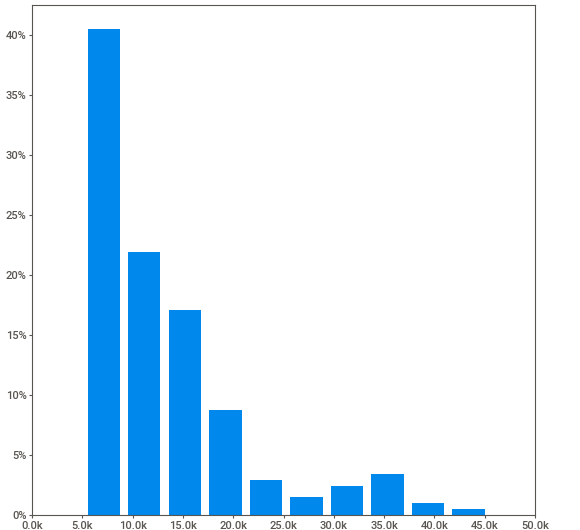
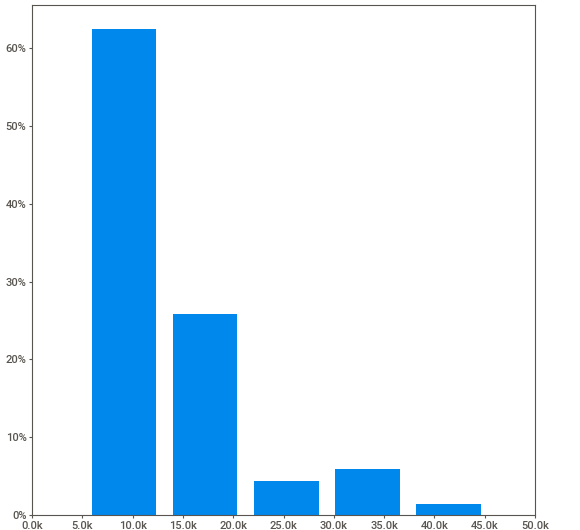
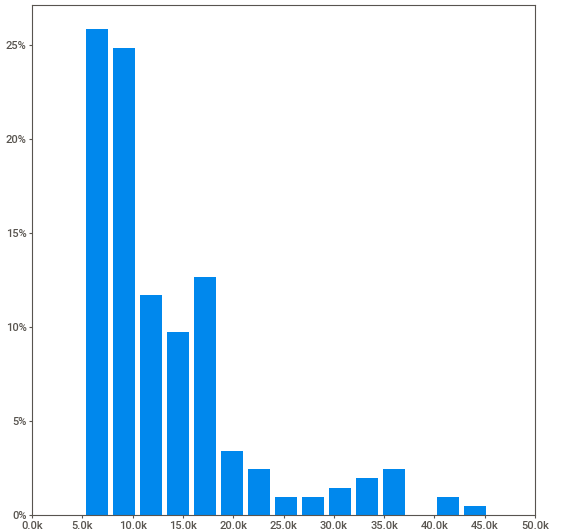
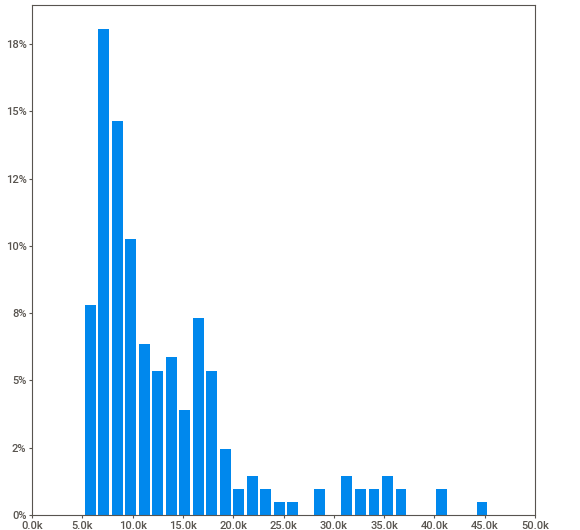
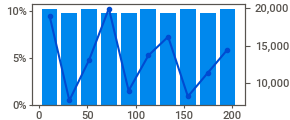
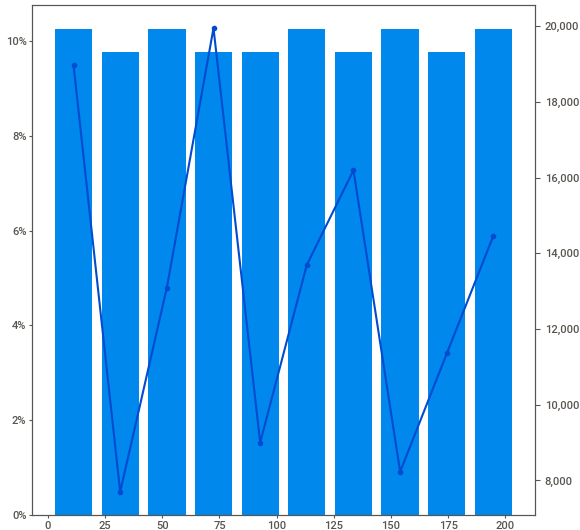
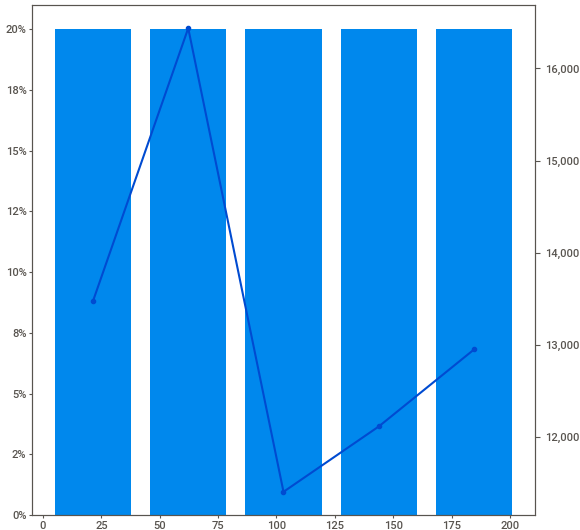
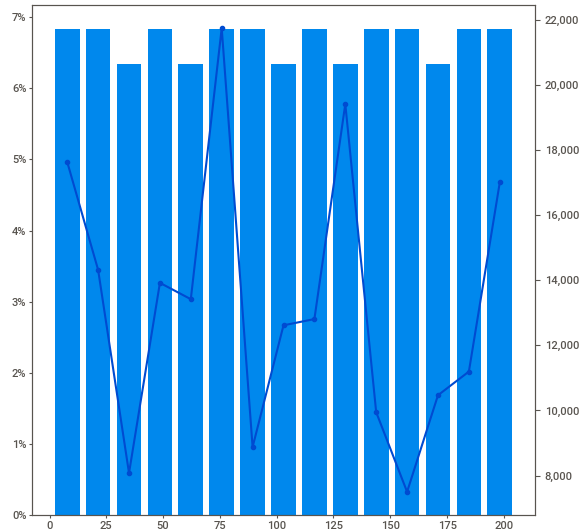
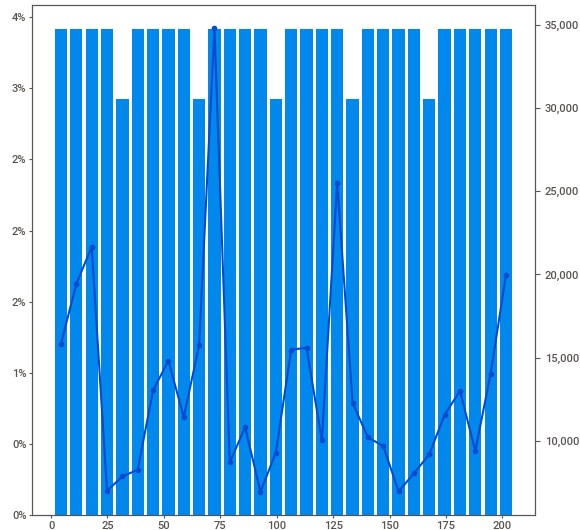
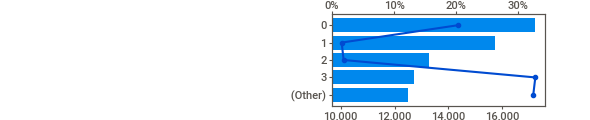
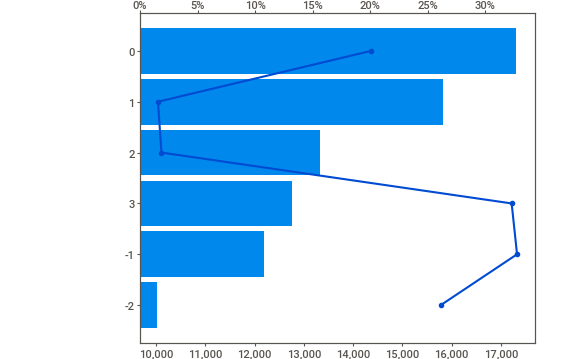
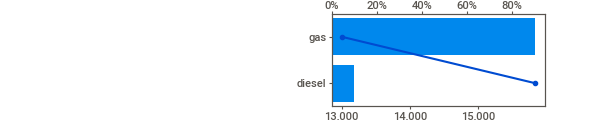
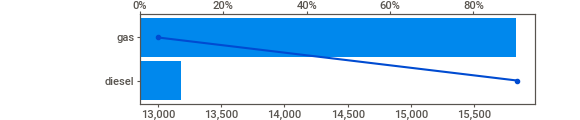
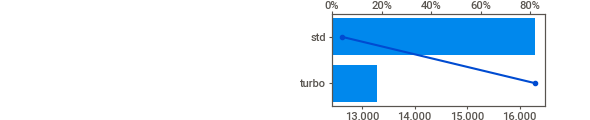
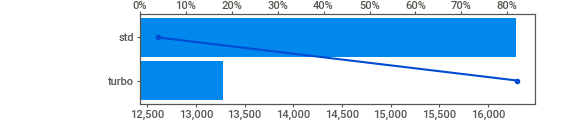
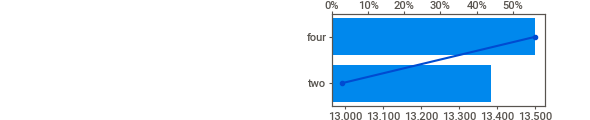
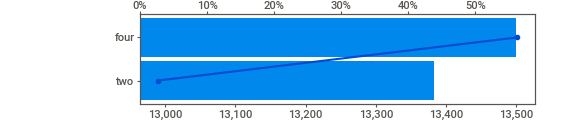
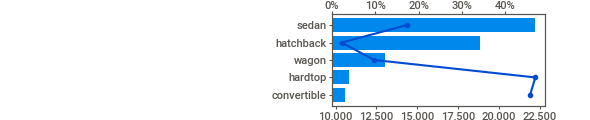
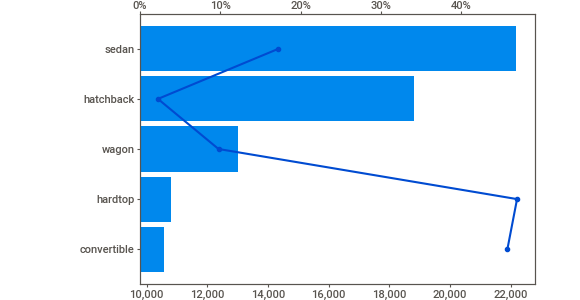
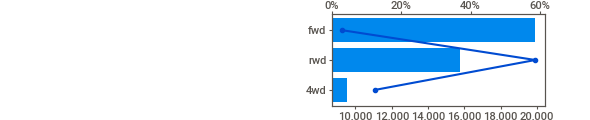
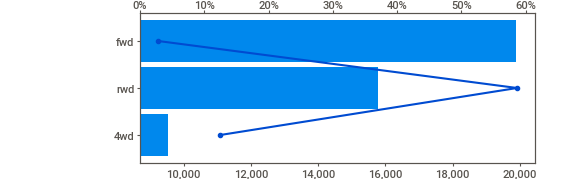
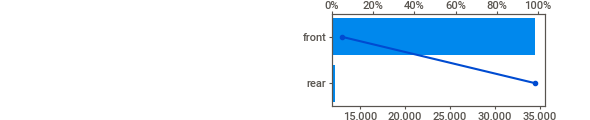
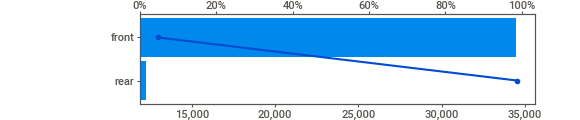
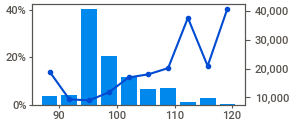
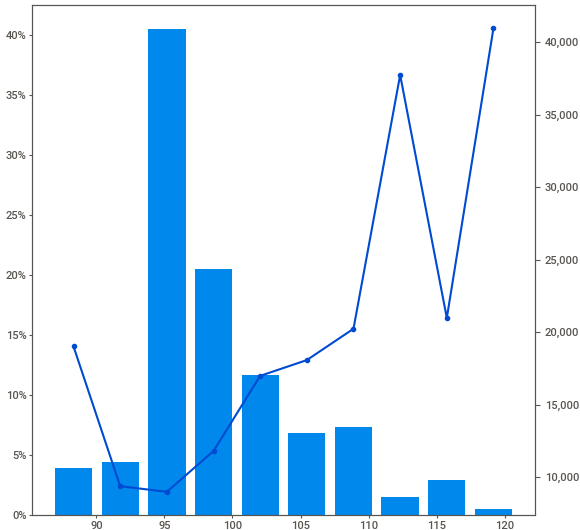
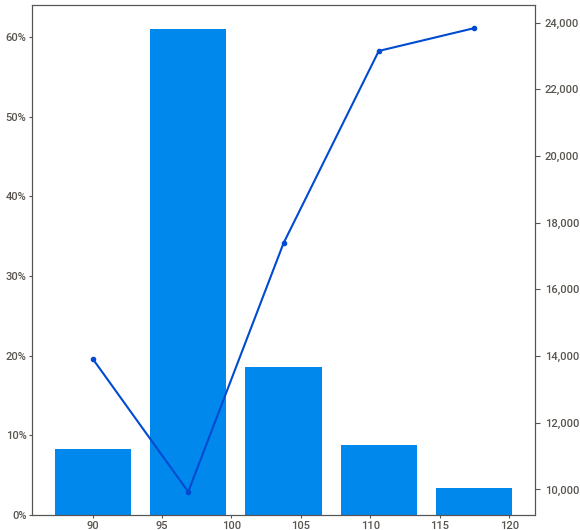
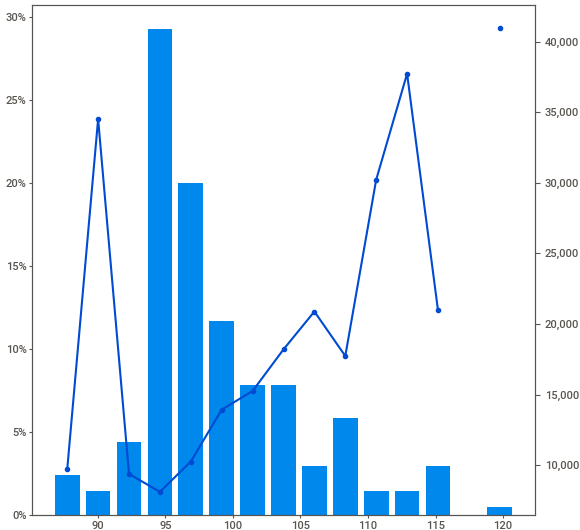
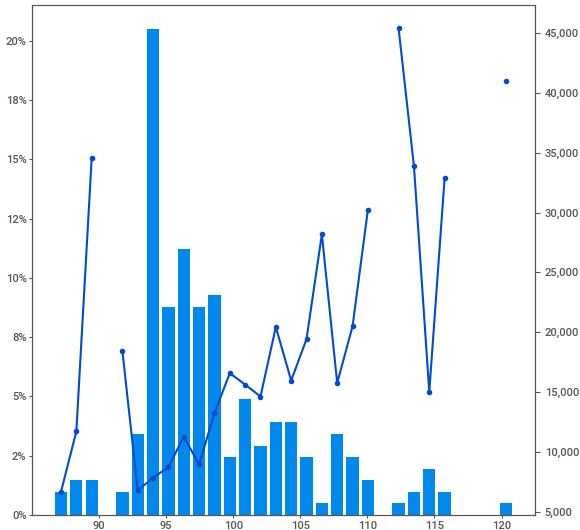
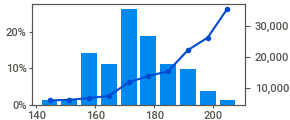
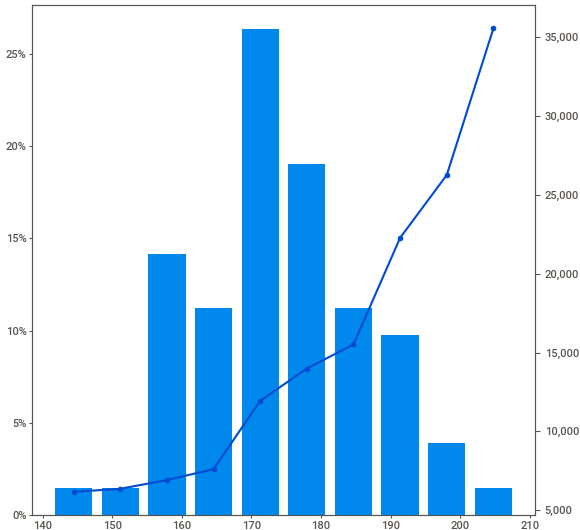
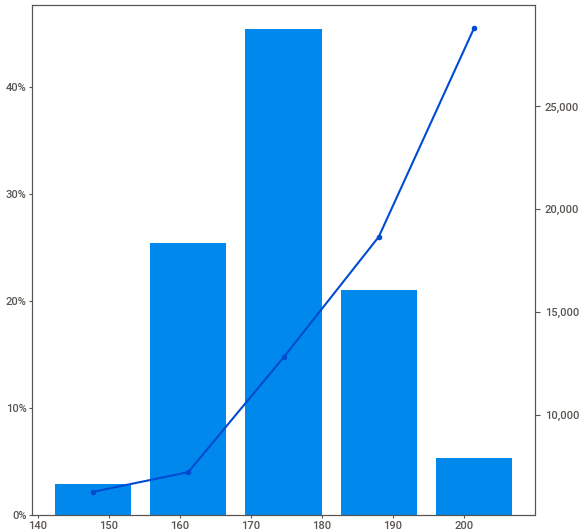
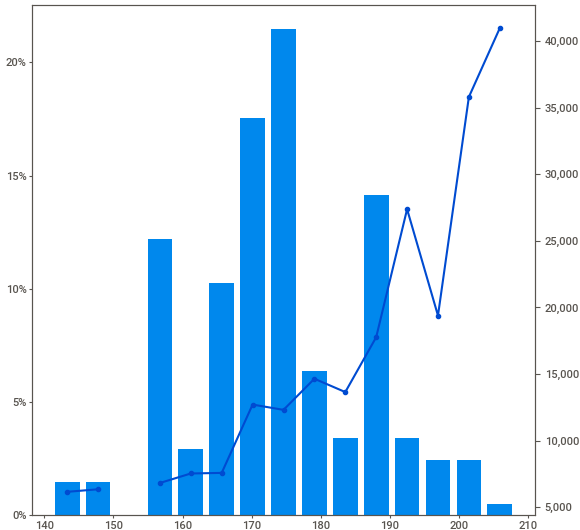
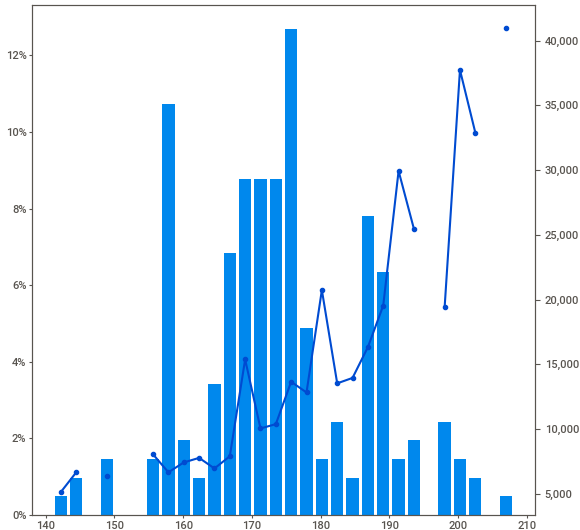
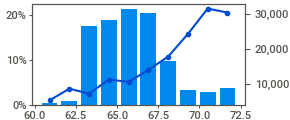
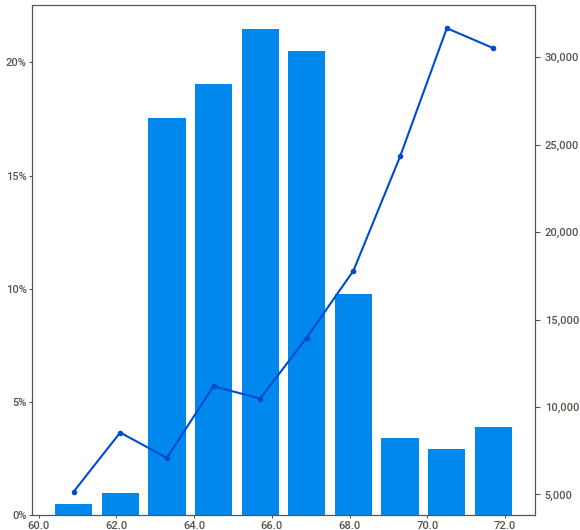
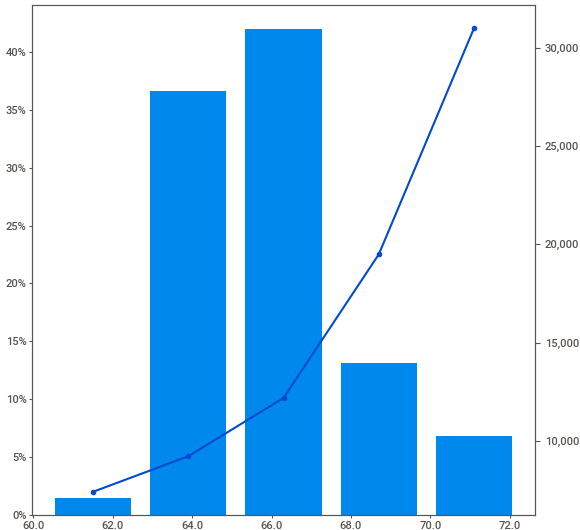
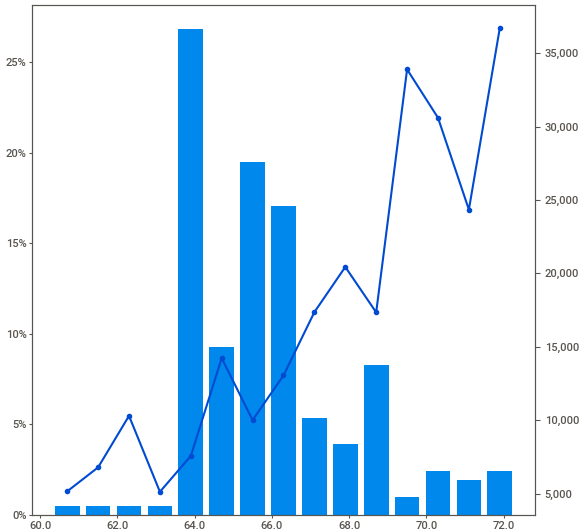
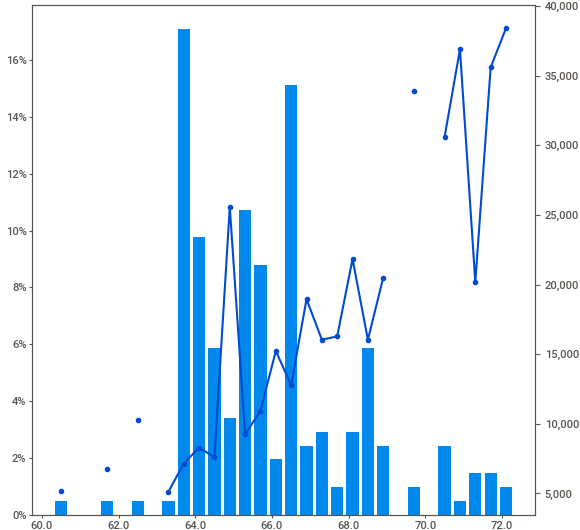
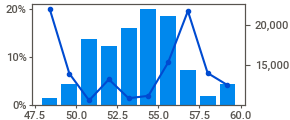
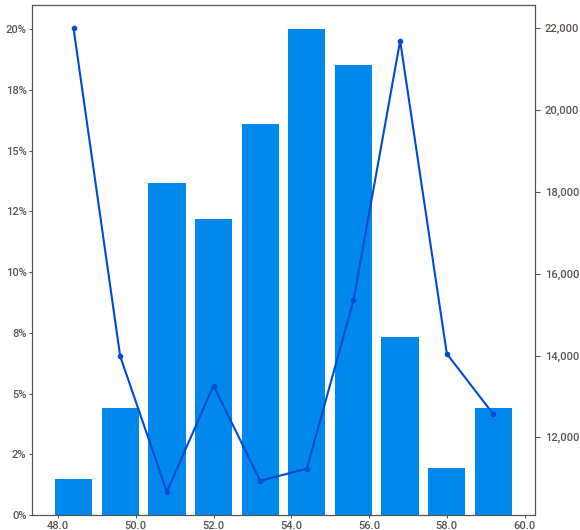
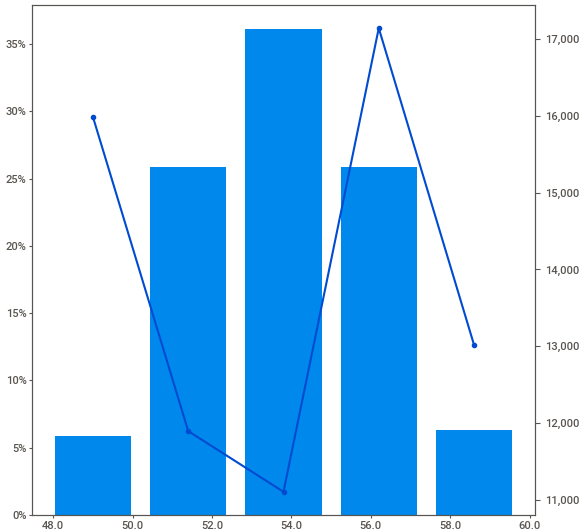
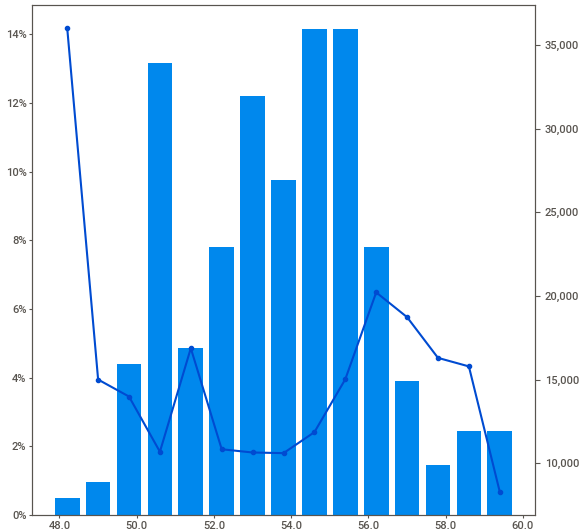
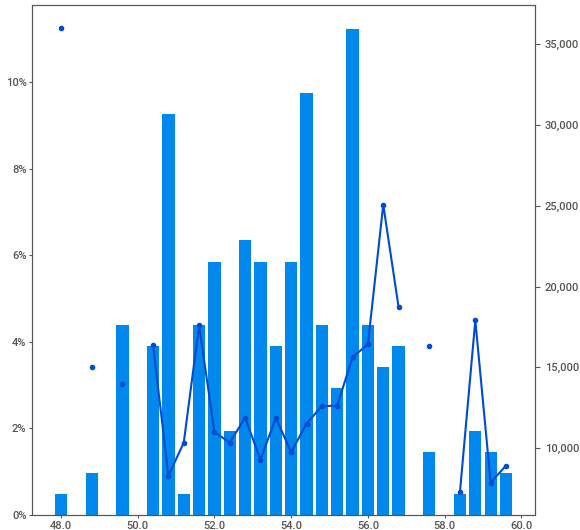
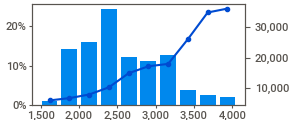
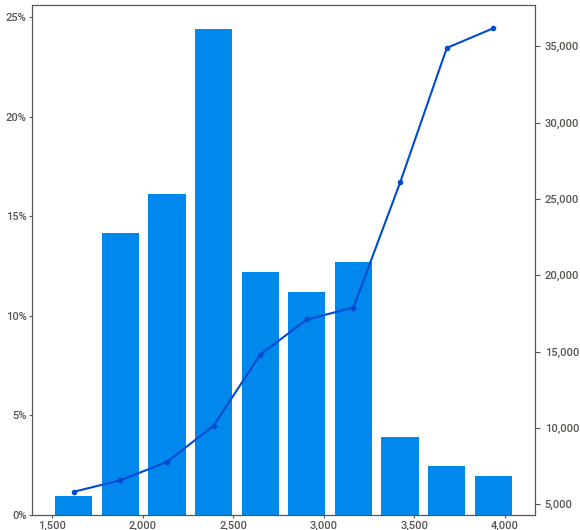
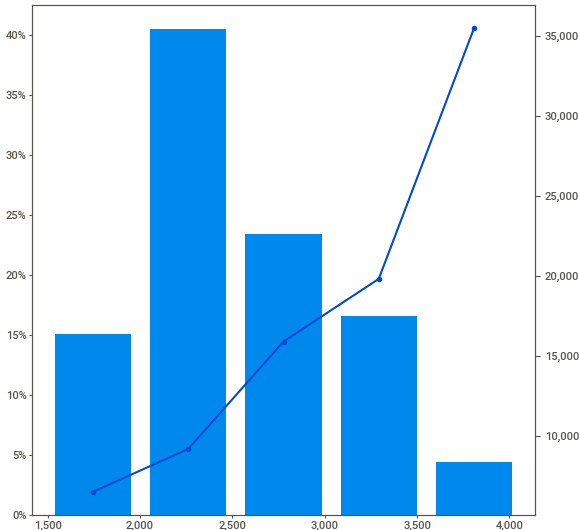
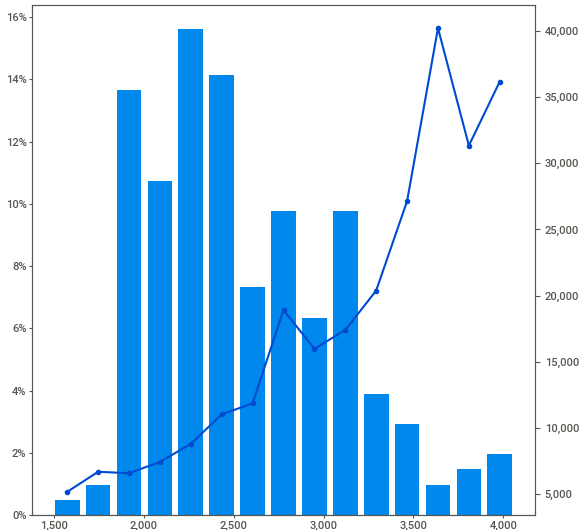
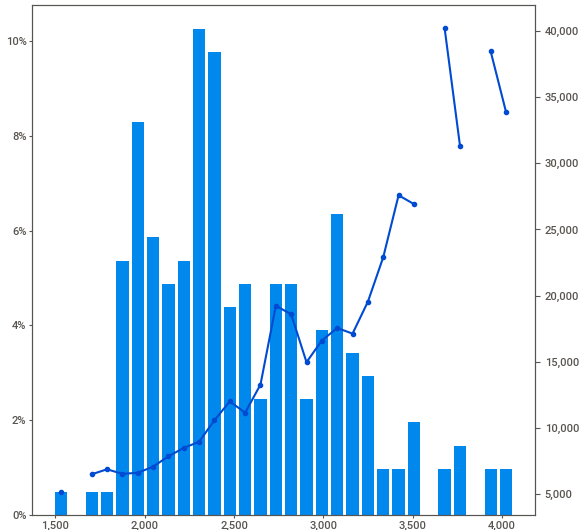
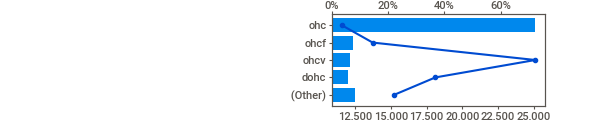
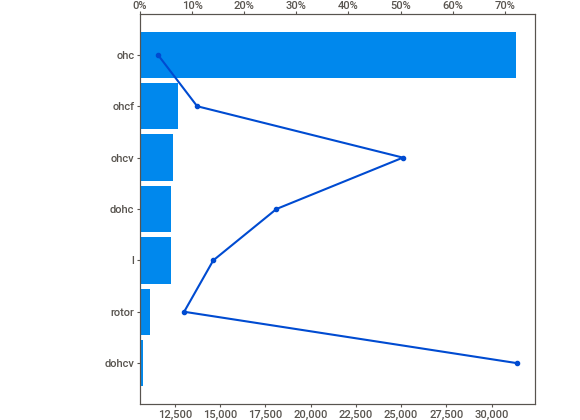
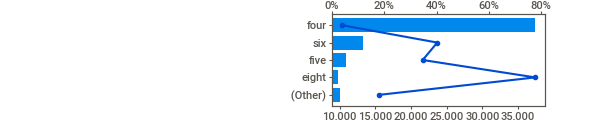
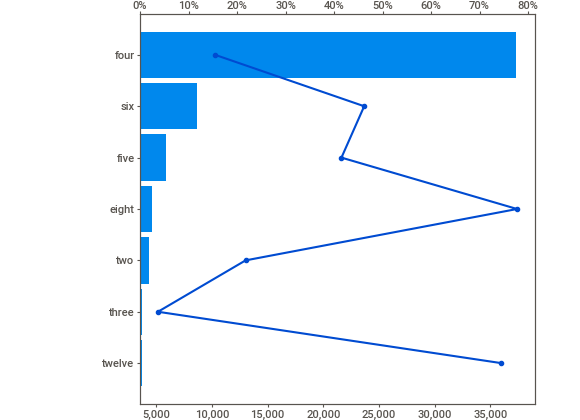
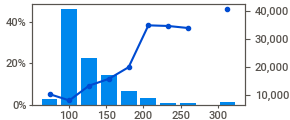
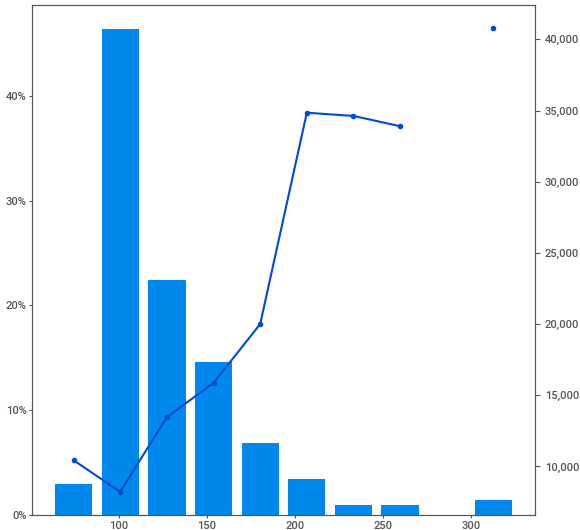
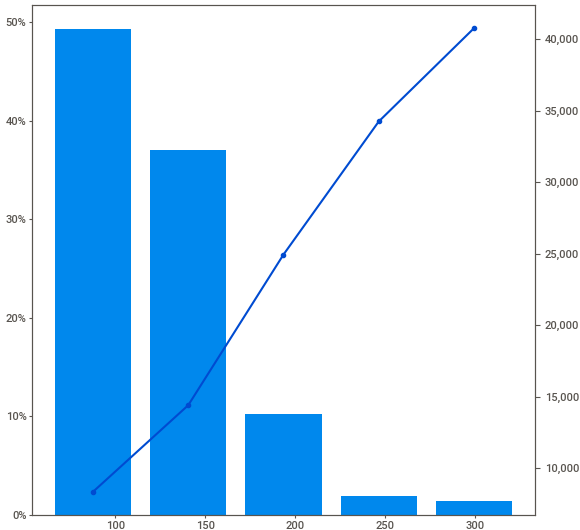
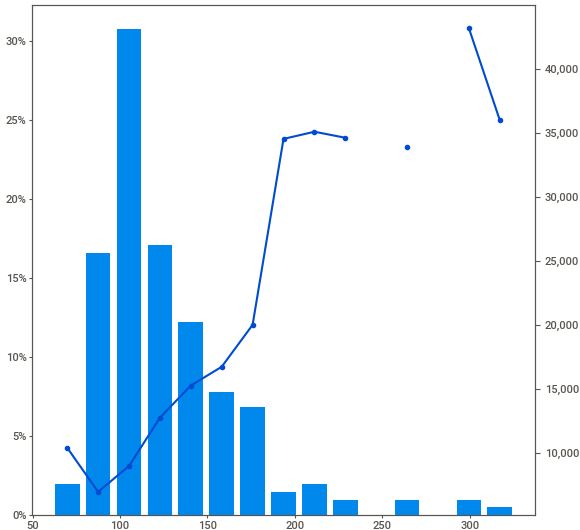
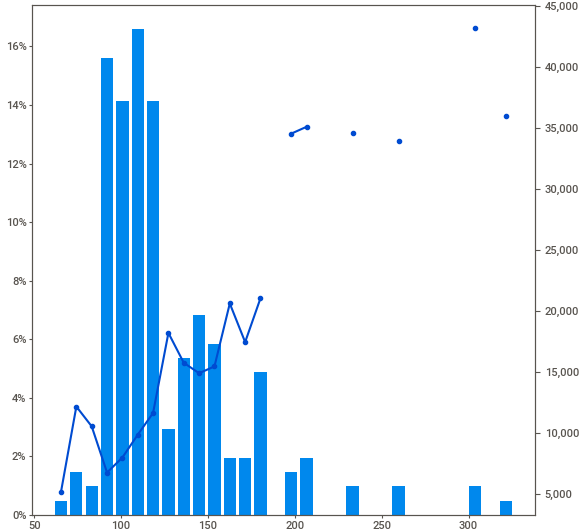
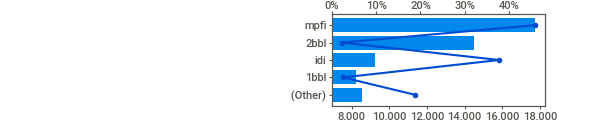
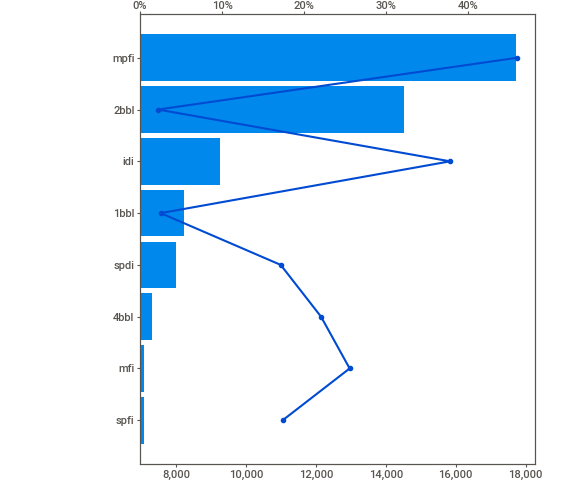
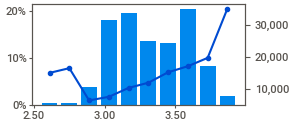
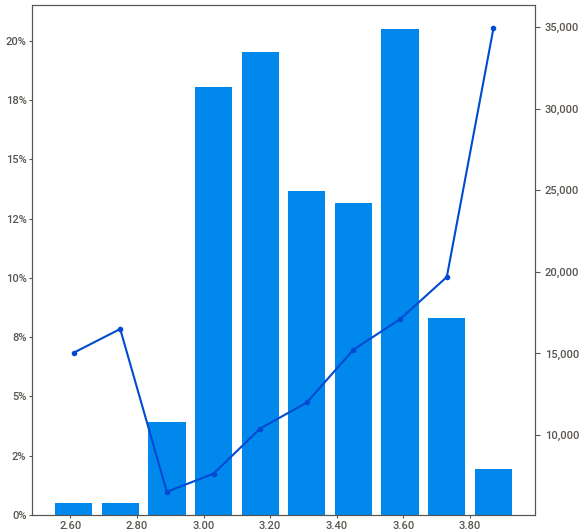
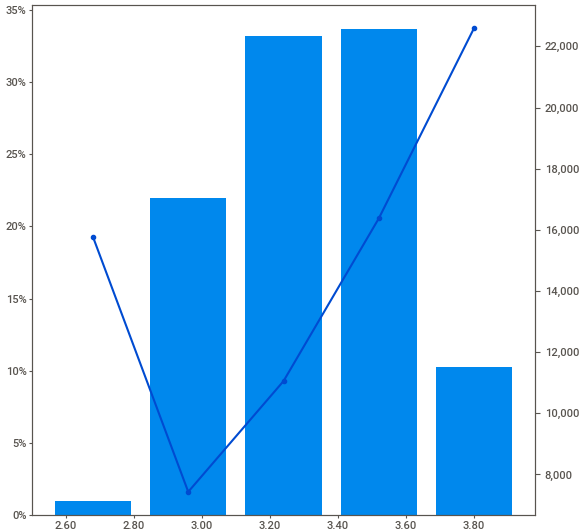
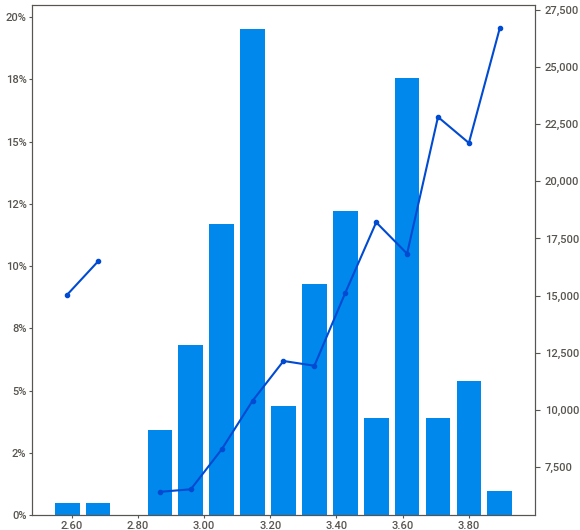
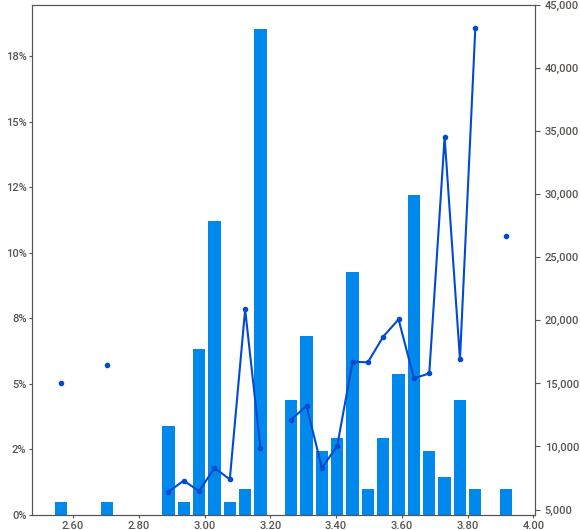
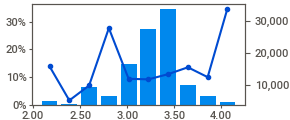
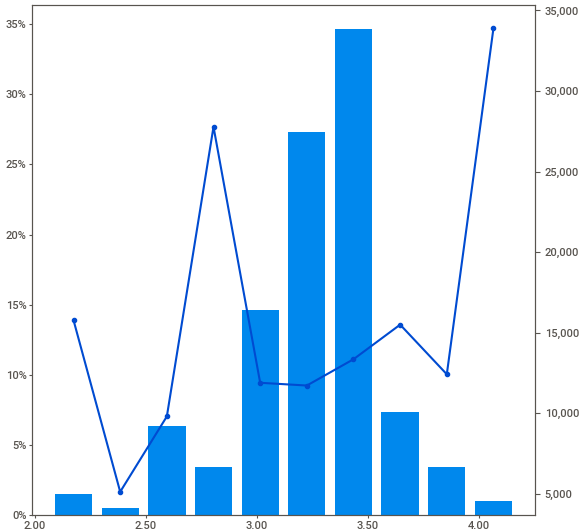
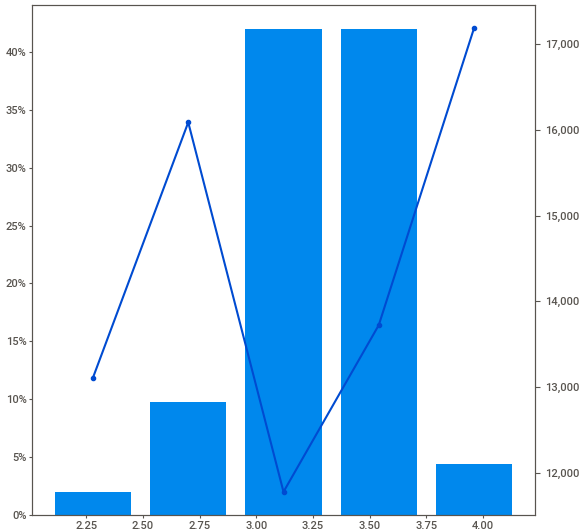
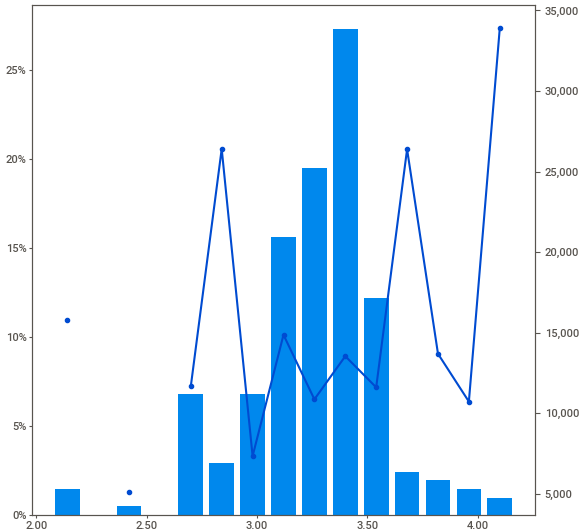
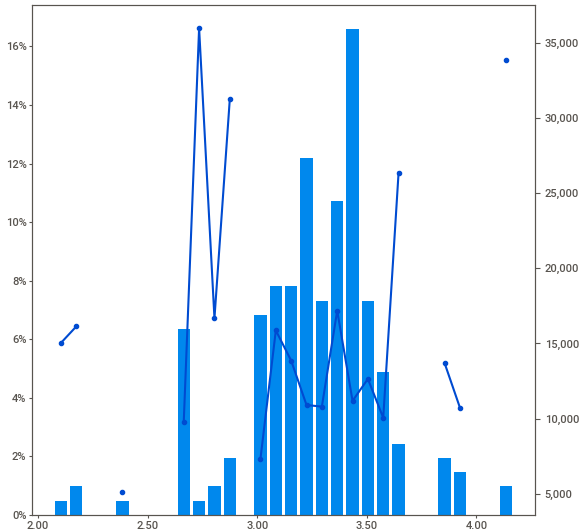
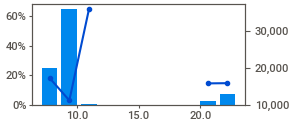
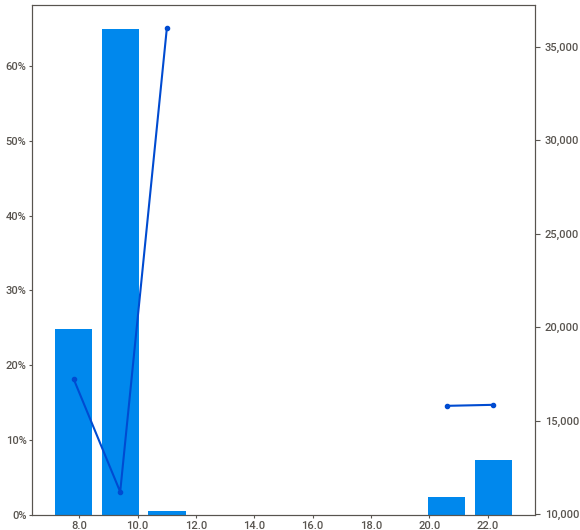
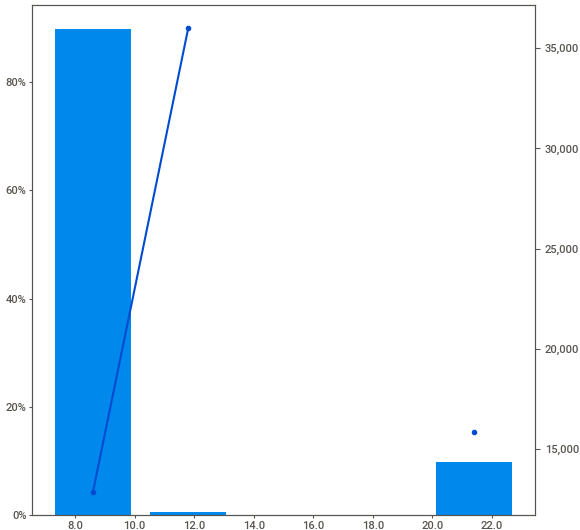
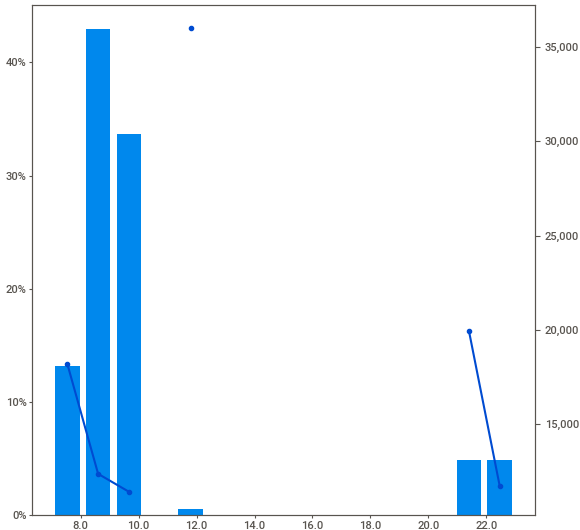
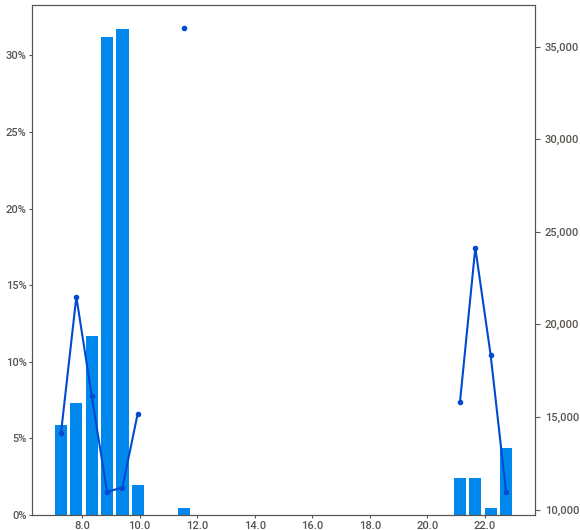
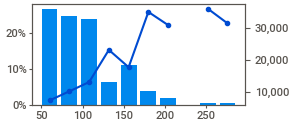
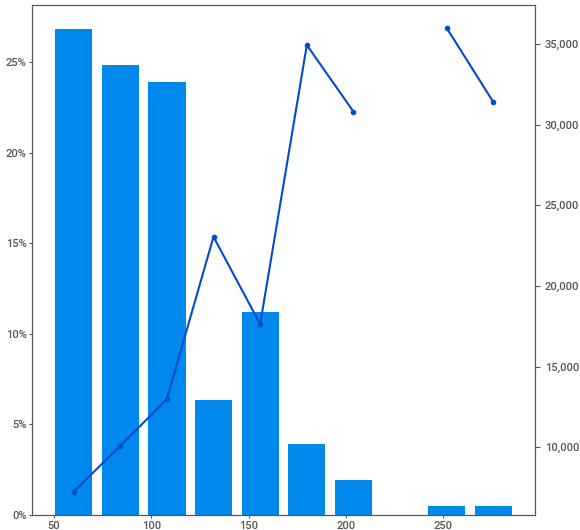
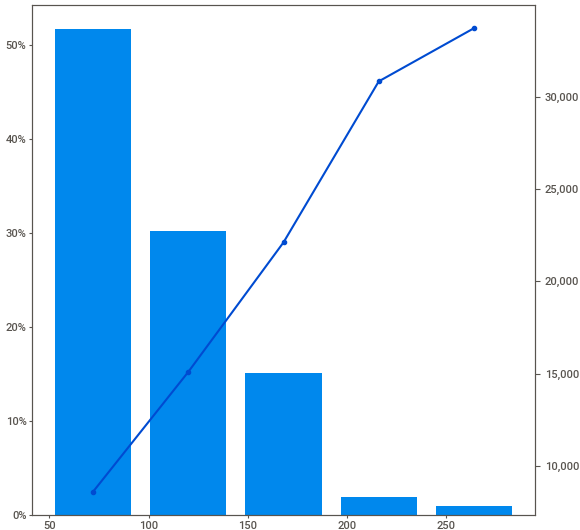
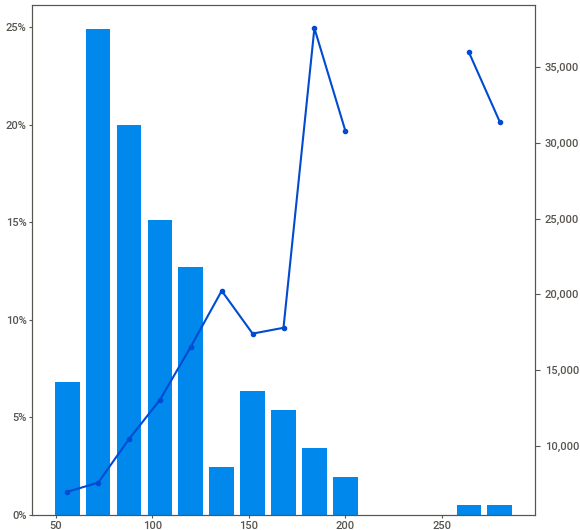
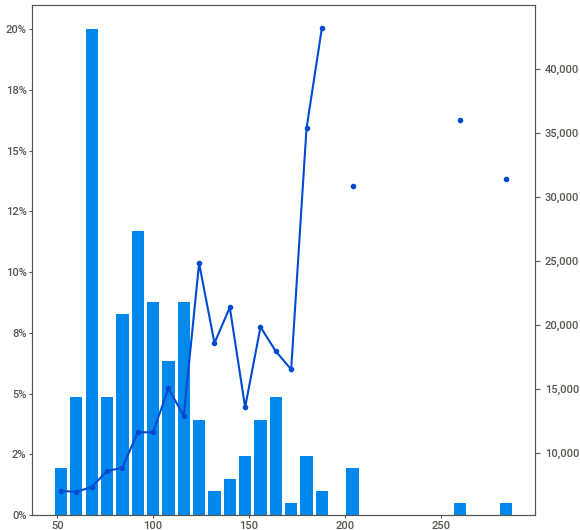
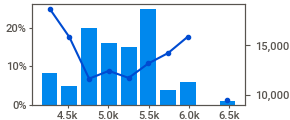
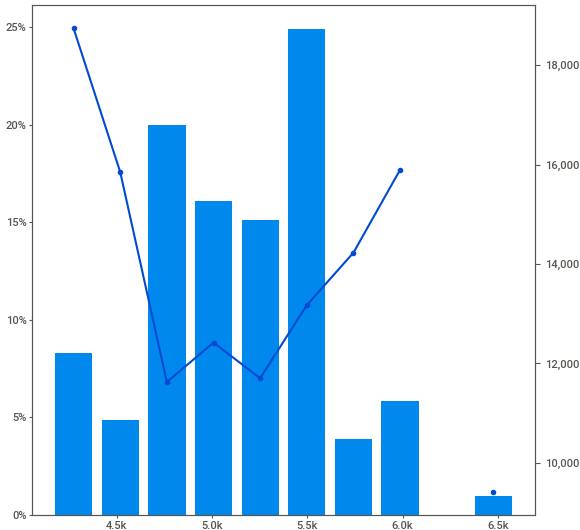
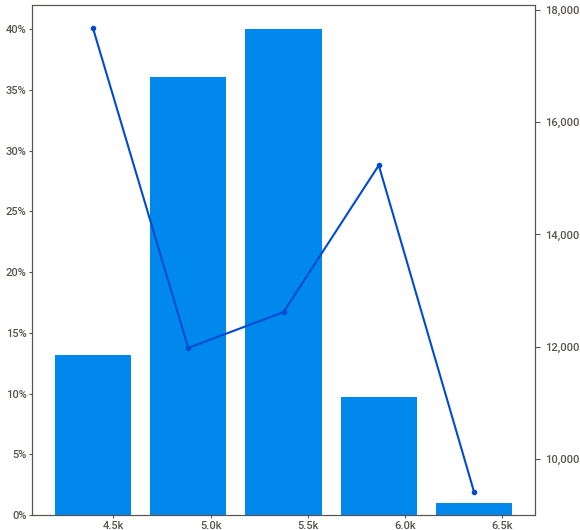
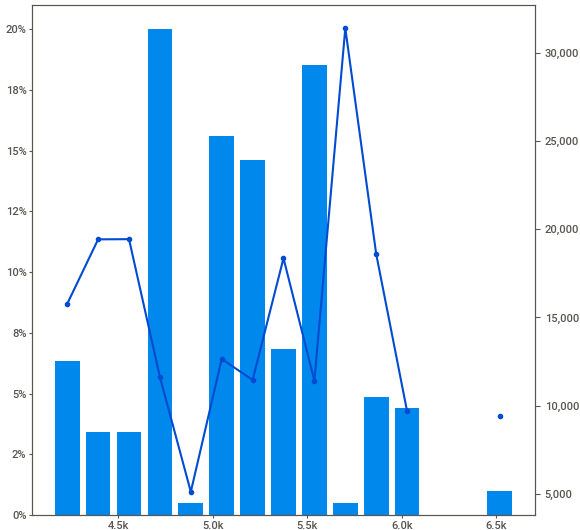
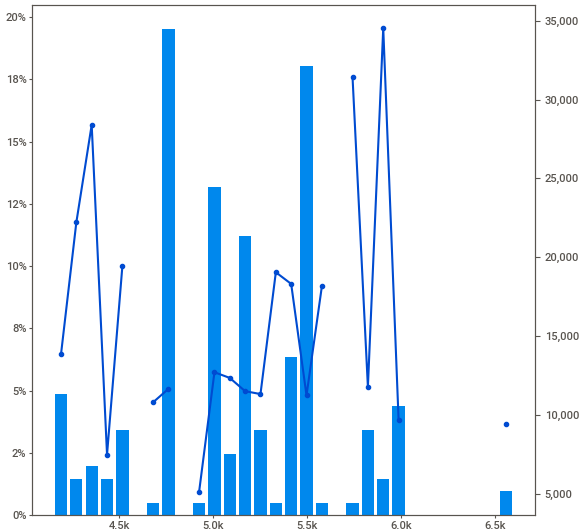
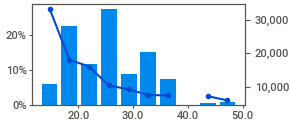
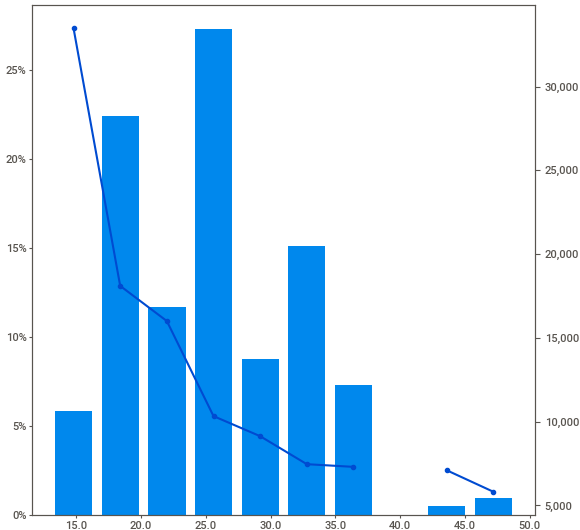
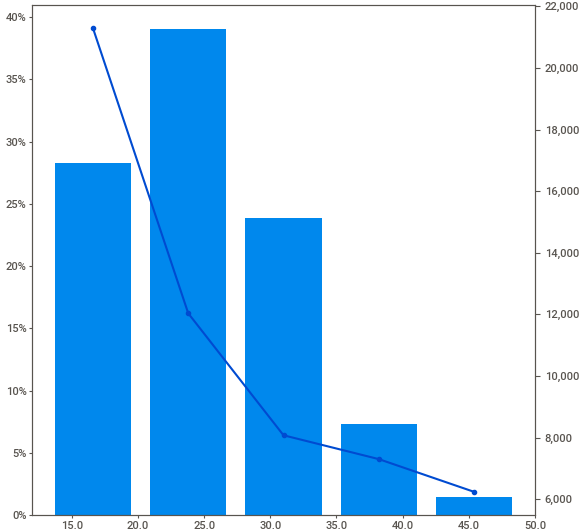
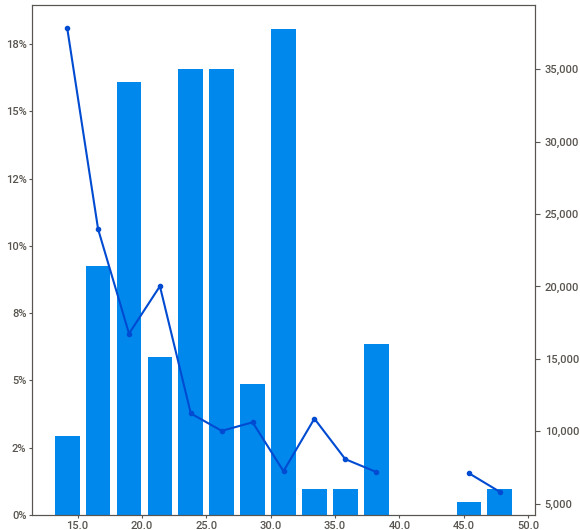
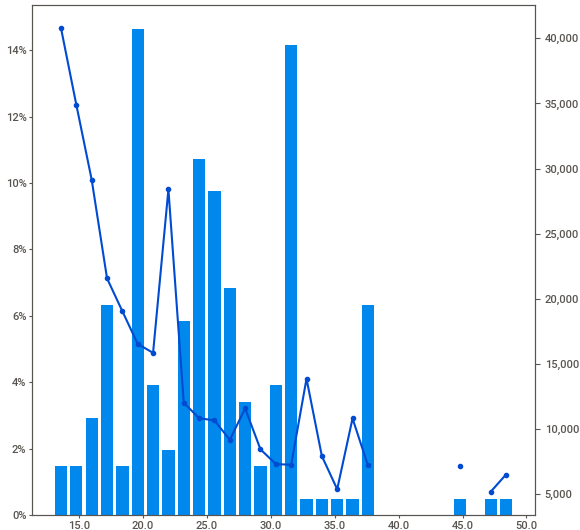
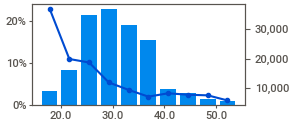
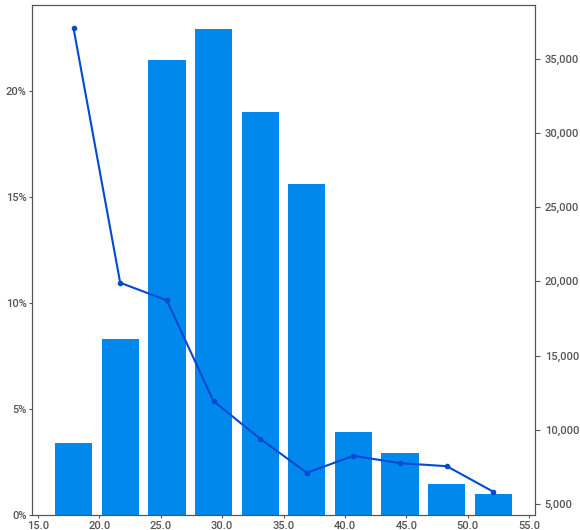
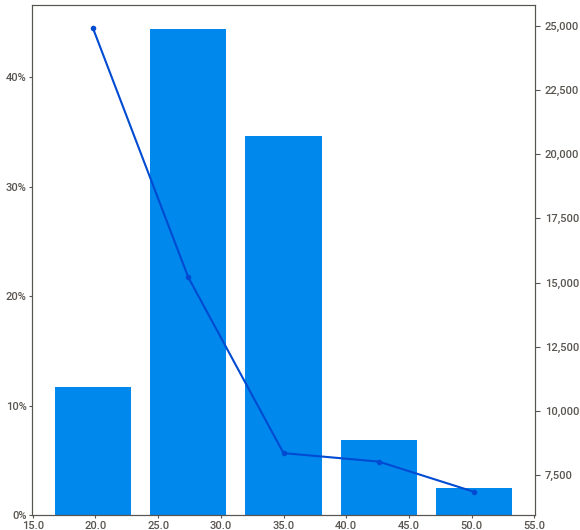
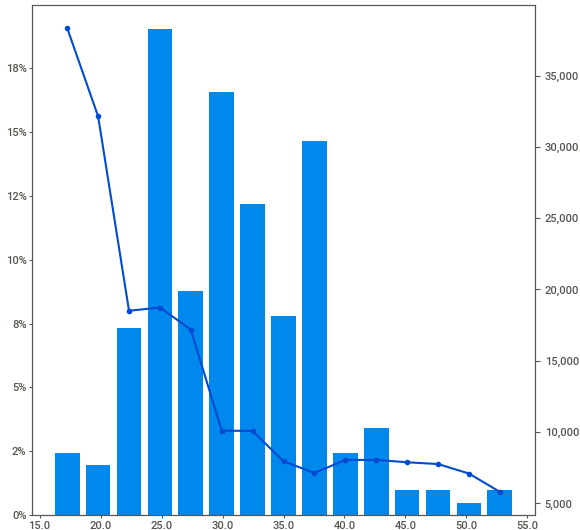
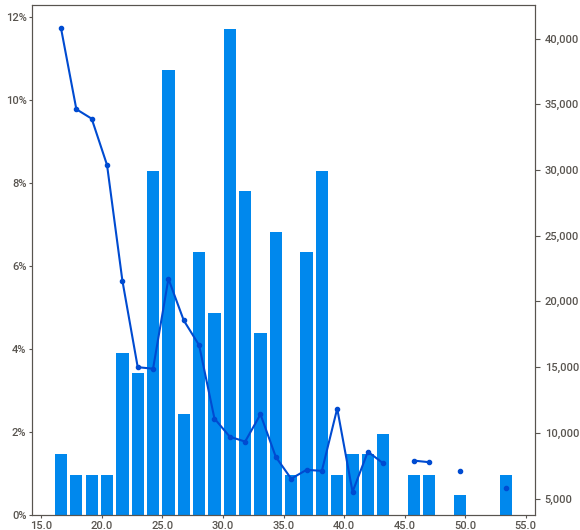
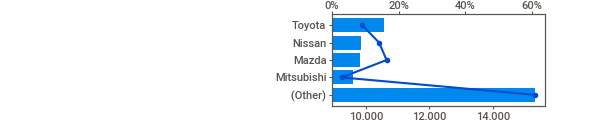
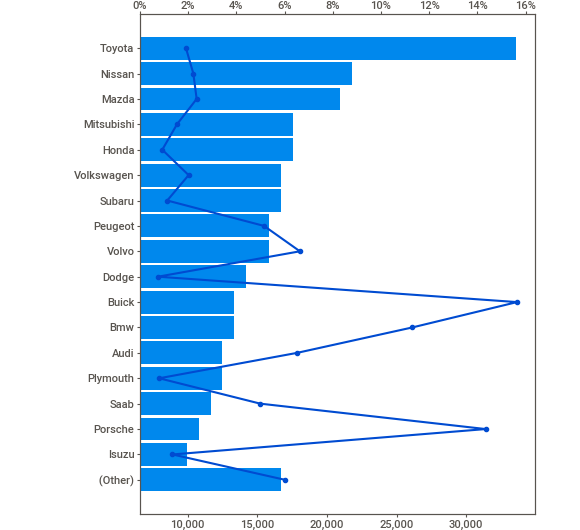
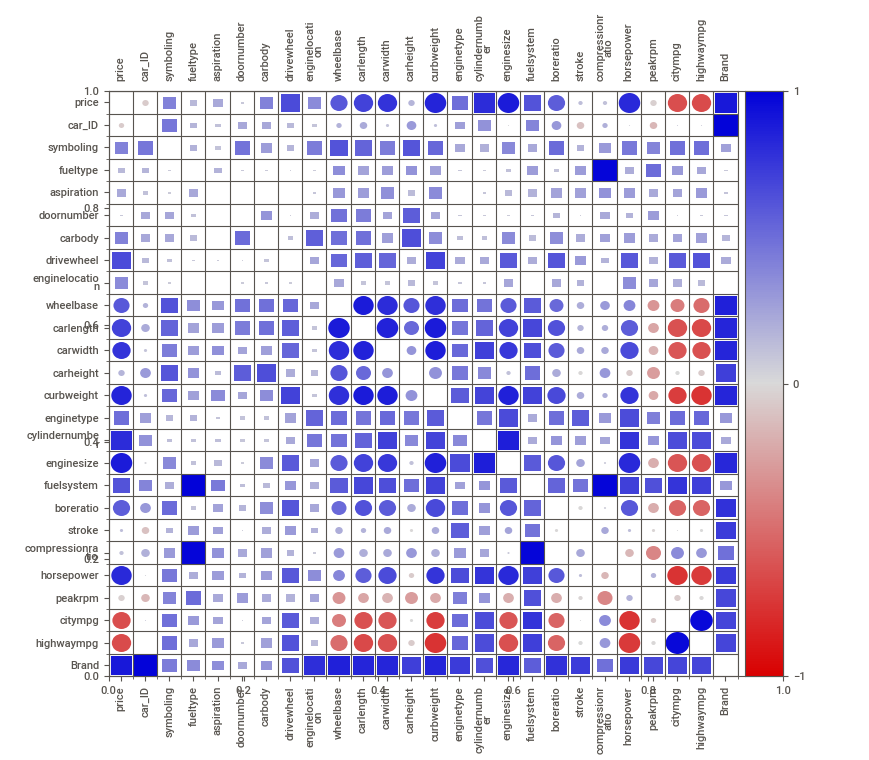
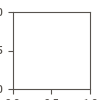

In [13]:
reporte_precio.show_notebook()

Voy a tomar las variables cuyo Valor Absoluto de Correlacion sea mayor a 0.60 a ver como va

Como `highwaympg` y `citympg` ambas se refieren a consumo de Combustibles y sus Correlaciones son parecidas, para no redundar me quedaré con una sola

- `enginesize`: Tamaño del Motor
- `curbweight` : Peso del Vehículo sin Carga ni Ocupantes    
- `horsepower` : Potencia del Vehículo en Caballos de Fuerza
- `carwidth`    : Ancho del Vehículo
- `highwaympg`  : Consumo en Ruta en Millas por Galon
- `citympg`     : Consumo en Ciudad en Millas por Galon  
- `carlength`   : Largo del Vehículo
- `cylindernumber` : Numero de Cilindros del Motor
- `drivewheel` : Ubicacion del Volante del Conductor
- `fuelsystem` : Sistema de Administracion de combustible del Motor

In [15]:
features_columns = ['enginesize', 'curbweight', 'horsepower', 'carwidth', 'highwaympg', 'citympg', 'carlength',
                    'cylindernumber', 'drivewheel', 'fuelsystem', 'Brand' ]

numerical_columns = ['enginesize', 'curbweight', 'horsepower', 'carwidth', 'highwaympg', 'citympg', 'carlength', 'price']
# df = df_pandas[numerical_columns]
df_ = df[features_columns + ['price']]
X = df[features_columns]
y = df['price']

In [16]:
correlacion = df[numerical_columns].corr()

In [ ]:
X['cylindernumber'].value_counts()
X['drivewheel'].value_counts()
X['fuelsystem'].value_counts()

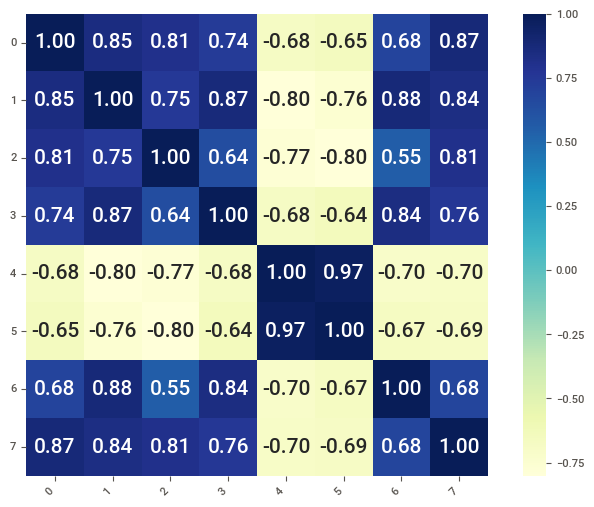

In [17]:
fig = plt.figure(figsize= (9,6))
sns.heatmap(correlacion, annot=True, cmap="YlGnBu", annot_kws={"size": 15  }, cbar=True, square=True, fmt='.2f')
plt.xticks(rotation=45, horizontalalignment='right')
plt.yticks(rotation=0)
plt.show()

In [18]:
# Numero de Cilindros 80% de Correlacion con respecto al Precio
df = df[features_columns + ['price']]
duckdb.sql("""
SELECT cylindernumber AS Num_Cilindros,
       ROUND(AVG(price),1) AS Precio_Promedio,
       COUNT(cylindernumber) AS Num_Muestras    
FROM df
GROUP BY 1
ORDER BY 2 DESC;    
""").show()

┌───────────────┬─────────────────┬──────────────┐
│ Num_Cilindros │ Precio_Promedio │ Num_Muestras │
│    varchar    │     double      │    int64     │
├───────────────┼─────────────────┼──────────────┤
│ eight         │         37400.1 │            5 │
│ twelve        │         36000.0 │            1 │
│ six           │         23671.8 │           24 │
│ five          │         21630.5 │           11 │
│ two           │         13020.0 │            4 │
│ four          │         10285.8 │          159 │
│ three         │          5151.0 │            1 │
└───────────────┴─────────────────┴──────────────┘



In [19]:
# Sistema de Inyeccion de Combustible 60% de Correlacion con respecto al Precio
duckdb.sql("""
SELECT fuelsystem AS Sistema_Combustible,
       ROUND(AVG(price),1) AS Precio_Promedio,
       COUNT(fuelsystem) AS Num_Muestras 
FROM df
GROUP BY 1
ORDER BY 2 DESC;    
""").show()

┌─────────────────────┬─────────────────┬──────────────┐
│ Sistema_Combustible │ Precio_Promedio │ Num_Muestras │
│       varchar       │     double      │    int64     │
├─────────────────────┼─────────────────┼──────────────┤
│ mpfi                │         17754.6 │           94 │
│ idi                 │         15838.2 │           20 │
│ mfi                 │         12964.0 │            1 │
│ 4bbl                │         12145.0 │            3 │
│ spfi                │         11048.0 │            1 │
│ spdi                │         10990.4 │            9 │
│ 1bbl                │          7555.5 │           11 │
│ 2bbl                │          7478.2 │           66 │
└─────────────────────┴─────────────────┴──────────────┘



In [20]:
# Sistema de Traccion 64% Correlacion con respecto al Precio
duckdb.sql("""
SELECT drivewheel AS Sistema_Traccion,
       ROUND(AVG(price),1) AS Precio_Promedio,
       COUNT(drivewheel) AS Num_Muestras 
FROM df
GROUP BY 1
ORDER BY 2 DESC;    
""").show()

┌──────────────────┬─────────────────┬──────────────┐
│ Sistema_Traccion │ Precio_Promedio │ Num_Muestras │
│     varchar      │     double      │    int64     │
├──────────────────┼─────────────────┼──────────────┤
│ rwd              │         19910.8 │           76 │
│ 4wd              │         11087.5 │            9 │
│ fwd              │          9239.3 │          120 │
└──────────────────┴─────────────────┴──────────────┘



In [21]:
# Precio 90% de Correlacion con respecto al Precio
duckdb.sql("""
SELECT Brand AS Marca,
       ROUND(AVG(price),1) AS Precio_Promedio,
       COUNT(Brand) AS Num_Muestras 
FROM df
GROUP BY 1
ORDER BY 2 DESC;    
""").show()

┌────────────┬─────────────────┬──────────────┐
│   Marca    │ Precio_Promedio │ Num_Muestras │
│  varchar   │     double      │    int64     │
├────────────┼─────────────────┼──────────────┤
│ Jaguar     │         34600.0 │            3 │
│ Buick      │         33647.0 │            8 │
│ Porsche    │         31400.5 │            5 │
│ Bmw        │         26118.8 │            8 │
│ Volvo      │         18063.2 │           11 │
│ Audi       │         17859.2 │            7 │
│ Mercury    │         16503.0 │            1 │
│ Alfa-Romeo │         15498.3 │            3 │
│ Peugeot    │         15489.1 │           11 │
│ Saab       │         15223.3 │            6 │
│ Mazda      │         10652.9 │           17 │
│ Nissan     │         10415.7 │           18 │
│ Volkswagen │         10077.5 │           12 │
│ Toyota     │          9885.8 │           32 │
│ Renault    │          9595.0 │            2 │
│ Mitsubishi │          9239.8 │           13 │
│ Isuzu      │          8916.5 │        

In [22]:
duckdb.sql("""SELECT COUNT (DISTINCT Brand) FROM df;""").show()

┌───────────────────────┐
│ count(DISTINCT Brand) │
│         int64         │
├───────────────────────┤
│                    22 │
└───────────────────────┘



In [24]:
duckdb.sql("""
SELECT ROUND(price,1) AS Precio,
       Brand AS Marca,
       
       drivewheel AS Traccion,
       fuelsystem AS Inyeccion,
       cylindernumber AS Cilindros
FROM df
WHERE price > 25000    
ORDER BY 1 DESC;           
""").show()

┌─────────┬─────────┬──────────┬───────────┬───────────┐
│ Precio  │  Marca  │ Traccion │ Inyeccion │ Cilindros │
│ double  │ varchar │ varchar  │  varchar  │  varchar  │
├─────────┼─────────┼──────────┼───────────┼───────────┤
│ 45400.0 │ Buick   │ rwd      │ mpfi      │ eight     │
│ 41315.0 │ Bmw     │ rwd      │ mpfi      │ six       │
│ 40960.0 │ Buick   │ rwd      │ mpfi      │ eight     │
│ 37028.0 │ Porsche │ rwd      │ mpfi      │ six       │
│ 36880.0 │ Bmw     │ rwd      │ mpfi      │ six       │
│ 36000.0 │ Jaguar  │ rwd      │ mpfi      │ twelve    │
│ 35550.0 │ Jaguar  │ rwd      │ mpfi      │ six       │
│ 35056.0 │ Buick   │ rwd      │ mpfi      │ eight     │
│ 34184.0 │ Buick   │ rwd      │ mpfi      │ eight     │
│ 34028.0 │ Porsche │ rwd      │ mpfi      │ six       │
│ 32528.0 │ Porsche │ rwd      │ mpfi      │ six       │
│ 32250.0 │ Jaguar  │ rwd      │ mpfi      │ six       │
│ 31600.0 │ Buick   │ rwd      │ idi       │ five      │
│ 31400.5 │ Porsche │ rwd      

In [25]:
print(duckdb.sql("""SELECT COUNT(*) AS NUM_rwd FROM df WHERE drivewheel = 'rwd';"""))  # Da 76
print(duckdb.sql("""SELECT COUNT(*) AS NUM_mpfi FROM df WHERE fuelsystem = 'mpfi';""")) # Da 94

┌─────────┐
│ NUM_rwd │
│  int64  │
├─────────┤
│      76 │
└─────────┘

┌──────────┐
│ NUM_mpfi │
│  int64   │
├──────────┤
│       94 │
└──────────┘



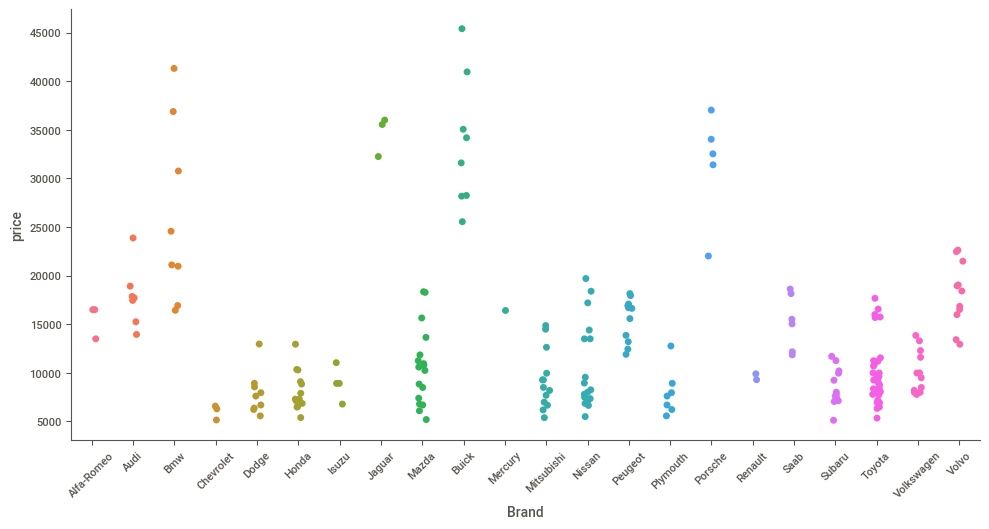

In [37]:
fig = sns.catplot(data=df.to_pandas(), 
                  x='Brand', 
                  y='price', 
                  errorbar='sd', 
                  estimator=np.median, 
                  hue='Brand',
                #   height=25,
                  aspect=2
                  )
fig.set_xticklabels(rotation=45)

plt.show()

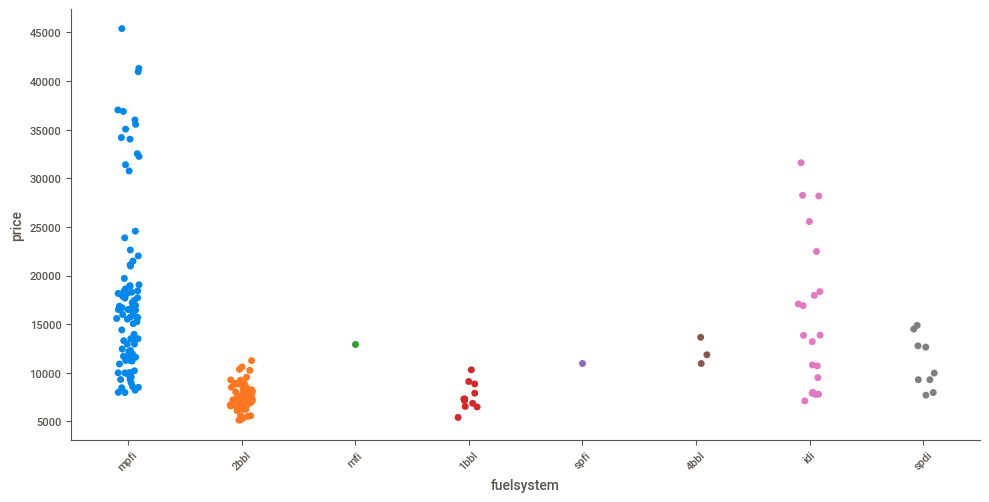

In [31]:
fig = sns.catplot(data=df.to_pandas(), 
                  x='fuelsystem', 
                  y='price', 
                  errorbar='sd', 
                  estimator=np.median, 
                  hue='fuelsystem',
                #   height=25,
                  aspect=2
                  )
fig.set_xticklabels(rotation=45)

plt.show()

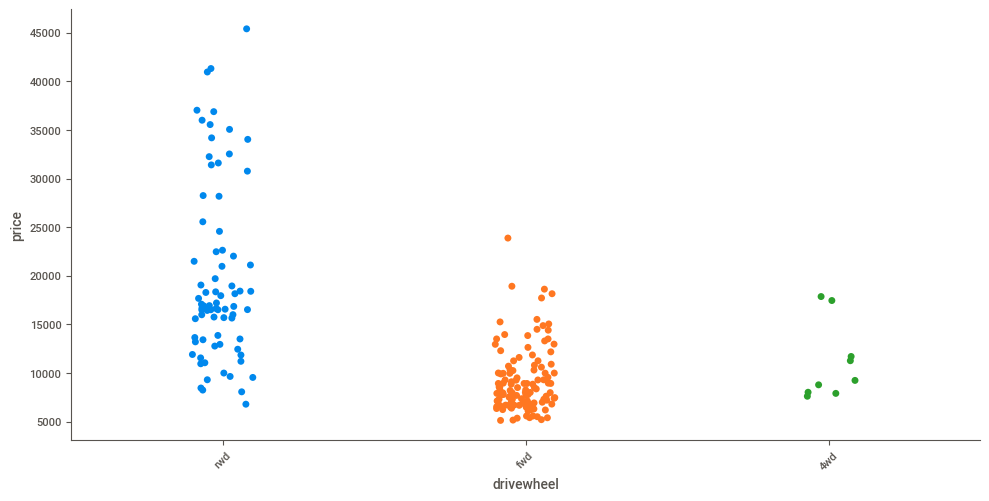

In [32]:
fig = sns.catplot(data=df.to_pandas(), 
                  x='drivewheel', 
                  y='price', 
                  errorbar='sd', 
                  estimator=np.median, 
                  hue='drivewheel',
                #   height=25,
                  aspect=2
                  )
fig.set_xticklabels(rotation=45)

plt.show()

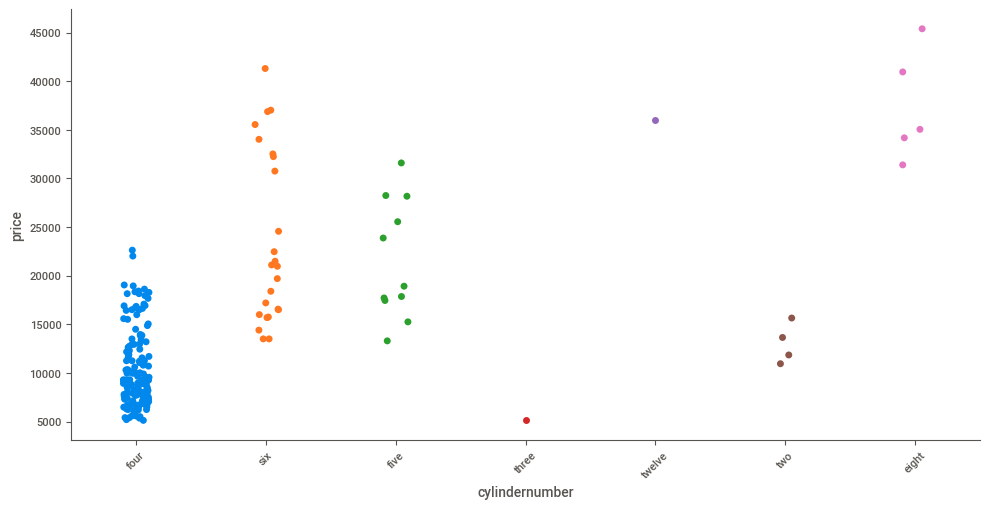

In [33]:
fig = sns.catplot(data=df.to_pandas(), 
                  x='cylindernumber', 
                  y='price', 
                  errorbar='sd', 
                  estimator=np.median, 
                  hue='cylindernumber',
                #   height=25,
                  aspect=2
                  )
fig.set_xticklabels(rotation=45)

plt.show()

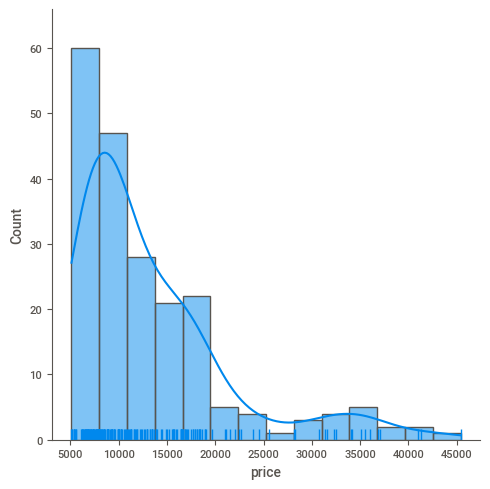

In [34]:
sns.displot(df.to_pandas()['price'],kind='hist' , kde=True, rug=True)
plt.show()

In [ ]:
df

In [35]:
predictors = ['enginesize', 'curbweight', 'horsepower', 'carwidth', 'citympg', 'carlength', 'Brand', 'cylindernumber']

In [36]:
duckdb.sql("""
SELECT MIN(enginesize) AS min_enginesize,
       MAX(enginesize) AS max_enginesize,
       MIN(curbweight) AS min_curbweight,
       MAX(curbweight) AS max_curbweight,
       MIN(horsepower) AS min_horsepower,
       MAX(horsepower) AS max_horsepower,  
       MIN(carwidth) AS min_carwidth,
       MAX(carwidth) AS max_carwidth,  
       MIN(citympg) AS min_citympg,
       MAX(citympg) AS max_citympg,  
       MIN(carlength) AS min_carlength,
       MAX(carlength) AS max_carlength,        
FROM df;
""").show()

┌────────────────┬────────────────┬────────────────┬────────────────┬───┬─────────────┬───────────────┬───────────────┐
│ min_enginesize │ max_enginesize │ min_curbweight │ max_curbweight │ … │ max_citympg │ min_carlength │ max_carlength │
│     int64      │     int64      │     int64      │     int64      │   │    int64    │    double     │    double     │
├────────────────┼────────────────┼────────────────┼────────────────┼───┼─────────────┼───────────────┼───────────────┤
│             61 │            326 │           1488 │           4066 │ … │          49 │         141.1 │         208.1 │
├────────────────┴────────────────┴────────────────┴────────────────┴───┴─────────────┴───────────────┴───────────────┤
│ 1 rows                                                                                         12 columns (7 shown) │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘



In [ ]:
enginesizes = [61, 326]
curbweights = [1488, 4066]
citympgs = [13, 49]
carlenght = [141.1, 208.1]
horspowers = [48, 288]
carwidths = [60.3, 72.3]
brands = ['Bmw', 'Volvo', 'Plymouth', 'Mitsubishi', 'Buick', 'Subaru', 'Volkswagen', 'Toyota', 'Jaguar', 'Dodge', 'Mazda',
          'Porsche', 'Alfa-romeo', 'Audi', 'Nissan', 'Isuzu', 'Chevrolet', 'Mercury', 'Saab', 'Renault', 'Peugeot', 'Honda']
cylindernumbers = ['two',  'three', 'four', 'five', 'six', 'eight', 'twelve']

In [ ]:
cylindernumbers

In [ ]:
brands = list(df['Brand'].unique())
cylindernumbers = list(df['cylindernumber'].unique())

min_enginesize = df['enginesize'].min()
max_enginesize = df['enginesize'].max()

min_curbweight = df['curbweight'].min()
max_curbweight = df['curbweight'].max()

min_horsepower = df['horsepower'].min()
max_horsepower = df['horsepower'].max()

min_carwidth = df['carwidth'].min()
max_carwidth = df['carwidth'].max()

min_citympg = df['citympg'].min()
max_citympg = df['citympg'].max()

min_carlength = df['carlength'].min()
max_carlength = df['carlength'].max()


In [ ]:
predictors_price = ['enginesize', 'curbweight', 'horsepower', 'carwidth', 'citympg', 'carlength', 'Brand', 'cylindernumber', 'price']
df = df[predictors_price]

In [ ]:
df.write_csv('test_proyecto2.csv')